# LeBron James: The Offensive Evolution in the NBA

In this notebook we present an analysis of the evolution of LeBron James' offensive game, in terms of shot selection and efficiency, over the course of his NBA career. In particular, we analyze data from the regular seasons from 2003-2004 to 2019-2024, with the aim of understanding how his game has changed over the years and how this has influenced the offensive production of his teams.
To be more specific, we will focus on the following aspects:

- Shot selection: how has LeBron's shot selection evolved over the years? Has he changed the types of shots he takes, such as moving from mid-range to three-point shots?
- Efficiency: how has LeBron's shooting efficiency evolved over the years? Has he become a more efficient scorer?
- Impact on team performance: how has LeBron's offensive evolution influenced the performance of his teams? Has he been able to improve the offensive production of his teams over the years?

First, let's import the necessary libraries and load all the datasets required for the analysis.

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from shapely.geometry import Polygon
from matplotlib.lines import Line2D

import warnings

# Ignora tutti i warning
warnings.filterwarnings("ignore")

from IPython.display import display, Markdown


# Load the data
df_shots = pd.read_pickle("LeBronShots.pickle")

df_advanced = pd.read_pickle("LeBronAdvanced.pickle")

Let's also initialize some variables that will be used throughout the analysis.

In [128]:
# Seasons arrays
cavs_1 = np.array(['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'])
mia = np.array(['2010-11', '2011-12', '2012-13', '2013-14'])
cavs_2 = np.array(['2014-15', '2015-16', '2016-17', '2017-18'])
lal = np.array(['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'])

# Concatenate seasons arrays
seasons = np.concatenate((cavs_1, mia, cavs_2, lal))

# Initialize discard counts for each zone
discards = {
    'Left Side Mid-Range': 0,
    'Right Side Mid-Range': 0,
    'Center Mid-Range': 0,
    'Left Side Corner 3': 0,
    'Left Side Three Point': 0,
    'Right Side Corner 3': 0,
    'Right Side Three Point': 0,
    'Center Three Point': 0,
    'In The Paint (Non Restricted)': 0,
    'Restricted Area': 0
}

# Initialize lists for each shooting zone
Left_Side_Mid_Range = []
Right_Side_Mid_Range = []
Center_Mid_Range = []
Left_Side_Corner_3 = []
Left_Side_Three_Point = []
Right_Side_Corner_3 = []
Right_Side_Three_Point = []
Center_Three_Point = []
In_The_Paint_Non_Restricted = []
Restricted_Area = []

# Eras labels
eras_label = ['Cleveland Cavs (1)', 'Miami Heat', 'Cleveland Cavs (2)', 'Los Angeles Lakers']

# Shot selection

To analyze LeBron's shot selection over the years, we will examine the distribution of his shot attempts by shot location (restricted area, paint, mid-range, corner 3, etc.). By comparing the distribution of shot attempts across different eras, we aim to understand how LeBron's shot selection has evolved over time.

For this analysis, we will use a customized version of EDU VADILLO's Kaggle dataset, which contains detailed information about LeBron's shot attempts, including shot location, shot type, and outcome. The dataset is available [here](https://www.kaggle.com/datasets/eduvadillo/lebron-james-career-shots).

In this initial part of the analysis, we will create a heatmap of LeBron's shot attempts by shot location for different eras to visualize the evolution of his shot selection over the years.


### NBA Court Chart
To start our analysis, we need to define an NBA court chart, which will serve as the basis for plotting shot data. Below is a function that creates a basketball court chart using the _matplotlib_ library. This function takes an axis object as input, on which the court will be plotted, and returns the axis object for further customization

This function is an adaptation of the one originally provided by Zach Gilbert in his project _"Visualizing NBA Shots with py-Goldsberry"_, which is available at this [linl](https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb).

In [129]:
#note: this function has benn optimized to plot more than one court at the same time

# Parameters
color = 'black'
lw = 2

def draw_court(ax=None):
    if ax is None:
        ax = plt.gca()

    # Elements of the court
    # Basketball hoop
    hoop = patches.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Backboard
    backboard = patches.Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Paint
    paint_lines = patches.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    
    # Free throw top arc
    free_throw = patches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    # Restricted area
    restricted_area = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Three point line
    # Side three point lines
    right_corner_side_line = patches.Rectangle((-220, -47.5), 0, 137.5, linewidth=lw, color=color)
    left_corner_side_line = patches.Rectangle((220, -47.5), 0, 137.5, linewidth=lw, color=color)

    # Three point arc
    three_arc = patches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    # Outer lines
    outer_lines = patches.Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)

    # List of court elements
    court_elements = [hoop, backboard, paint_lines, free_throw, restricted_area, right_corner_side_line, left_corner_side_line, three_arc, outer_lines]

    # Add the elements to the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


### Area Division Function

Once we have defined the court chart, we can implement a function to generate the areas into which the court is divided. Specifically, we will divide the court into 10 areas:

- Restricted Area
- In The Paint (Non-RA)
- Mid-Range Left
- Mid-Range Right
- Mid-Range Center
- Left Corner 3
- Right Corner 3
- Three Point Left
- Three Point Right
- Three Point Center

This function utilizes Polygon objects from the _shapely_ library to define specific areas. We start by constructing several polygons using the coordinates of the points that define the vertices of these areas. Then, we employ set operations on these polygons to create the desired areas.

The function returns a dictionary that maps each area to its corresponding polygon object.

In [130]:
# Function to create arc points
def create_arc_points(radius, start_angle, end_angle, num_points=100):
    theta = np.linspace(np.radians(start_angle), np.radians(end_angle), num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return np.column_stack((x, y))

# Create arc points
arc_x, arc_y = create_arc_points(237.5, 22, 158).T

# Create restricted area points
restricted_x, restricted_y = create_arc_points(40, 0, 180).T

# Define points for different shooting areas
Arc_points = np.column_stack((arc_x, arc_y))

ThreePointArea_Left_points = [(250, 422.5), (250, 90), (220, 90), (80, 142.5), (120, 422.5)]
ThreePointArea_Center_points = [(80, 142.5), (120, 422.5), (-120, 422.5), (-80, 142.5)]
ThreePointArea_Right_points = [(-250, 422.5), (-250, 90), (-220, 90), (-80, 142.5), (-120, 422.5)]
LeftCornerThree_points = [(220, -47.5), (220, 90), (250, 90), (250, -47.5)]
RightCornerThree_points = [(-220, -47.5), (-220, 90), (-250, 90), (-250, -47.5)]

MidRange_Left_points_Aux = [(120, 422.5), (80, 142.5), (80, -47.5), (220, -47.5), (220, 422.5)]
MidRange_Center_points = [(-80, 142.5), (-120, 422.5), (120, 422.5), (80, 142.5)]
MidRange_Right_points_Aux = [(-120, 422.5), (-80, 142.5), (-80, -47.5), (-220, -47.5), (-220, 422.5)]

Paint_points = [(80, -47.5), (80, 142.5), (-80, 142.5), (-80, -47.5)]

Restricted_Area_points1 = np.column_stack((restricted_x, restricted_y))
Restriced_Area_points2 = [(40, 0), (40, -10), (-40, -10), (-40, 0)]
Restricted_Area_points = np.vstack((Restricted_Area_points1, Restriced_Area_points2))

# Create Polygon objects from points
def create_polygons():
    Arc_Pol = Polygon(Arc_points)
    ThreePointArea_Left_Aux = Polygon(ThreePointArea_Left_points)
    ThreePointArea_Center_Aux = Polygon(ThreePointArea_Center_points)
    ThreePointArea_Right_Aux = Polygon(ThreePointArea_Right_points)
    LeftCornerThree = Polygon(LeftCornerThree_points)
    RightCornerThree = Polygon(RightCornerThree_points)
    MidRange_Left_Aux = Polygon(MidRange_Left_points_Aux)
    MidRange_Center_Aux = Polygon(MidRange_Center_points)
    MidRange_Right_Aux = Polygon(MidRange_Right_points_Aux)
    Paint = Polygon(Paint_points)
    Restricted_Area = Polygon(Restricted_Area_points)

    # Calculate differences to define final areas
    ThreePointArea_Left = ThreePointArea_Left_Aux.difference(Arc_Pol)
    ThreePointArea_Center = ThreePointArea_Center_Aux.difference(Arc_Pol)
    ThreePointArea_Right = ThreePointArea_Right_Aux.difference(Arc_Pol)
    MidRange_Center_Aux1 = MidRange_Center_Aux.difference(ThreePointArea_Center)
    MidRange_Center = MidRange_Center_Aux1.difference(Paint)
    MidRange_Left = MidRange_Left_Aux.difference(ThreePointArea_Left)
    MidRange_Right = MidRange_Right_Aux.difference(ThreePointArea_Right)

    # Create a dictionary with the areas
    areas = {
        'Left Side Mid-Range': MidRange_Left,
        'Right Side Mid-Range': MidRange_Right,
        'Center Mid-Range': MidRange_Center,
        'Left Side Corner 3': LeftCornerThree,
        'Left Side Three Point': ThreePointArea_Left,
        'Right Side Corner 3': RightCornerThree,
        'Right Side Three Point': ThreePointArea_Right,
        'Center Three Point': ThreePointArea_Center,
        'In The Paint (Non Restricted)': Paint,
        'Restricted Area': Restricted_Area
    }
    return areas

## Pre-Plotting Calculations
Before plotting the shot distribution, we need to determine the color and opacity for each area of the court, which will help visualize the hottest zones. This involves two key functions:

### Shot Distribution Function
Calculate Shot Distribution
This function computes the shot distribution percentage for a given dataset. It takes the dataset as input and returns a dictionary that maps each area to the percentage of shots attempted in that area.

#### Auxiliary Function: Generate Shot Attempts Dictionary
This function generates a dictionary that maps each area to the number of shots attempted in that area. It takes the dataset and the dictionary of areas as input, and returns the dictionary of shot attempts for each area.

In [131]:
def shots(data):
    # Calculate the number of shots attempted for each area
    LS_Mid = data[(data.Area == 'Left Side(L)') & (data.Zone == 'Mid-Range')].shape[0]
    RS_Mid = data[(data.Area == 'Right Side(R)') & (data.Zone == 'Mid-Range')].shape[0]
    C_Mid = data[(data.Area == 'Center(C)') & (data.Zone == 'Mid-Range')].shape[0]
    LS_Corner = data[(data.Zone == 'Left Corner 3')].shape[0]
    LS_Three = data[(data.Area == 'Left Side(L)') & (data.Zone == 'Above the Break 3')].shape[0]
    RS_Corner = data[(data.Zone == 'Right Corner 3')].shape[0]
    RS_Three = data[(data.Area == 'Right Side(R)') & (data.Zone == 'Above the Break 3')].shape[0]
    C_Three = data[(data.Area == 'Center(C)') & (data.Zone == 'Above the Break 3')].shape[0]
    Paint = data[(data.Zone == 'In The Paint (Non-RA)')].shape[0]
    Restricted = data[(data.Zone == 'Restricted Area')].shape[0]

    # Create a dictionary with the total number of shots attempted for each area
    attempts = {
        'Left Side Mid-Range': LS_Mid,
        'Right Side Mid-Range': RS_Mid,
        'Center Mid-Range': C_Mid,
        'Left Side Corner 3': LS_Corner,
        'Left Side Three Point': LS_Three,
        'Right Side Corner 3': RS_Corner,
        'Right Side Three Point': RS_Three,
        'Center Three Point': C_Three,
        'In The Paint (Non Restricted)': Paint,
        'Restricted Area': Restricted
    }

    return attempts


So we use the previous function to calculate the shot distribution for each era and then plot the shot distribution for each era.

In [132]:
def shot_distribution(data, seasons):
    #Calculate Shot Distribution: This function determines the shot distribution percentage for a given dataset.
    #Parameters:
    #data (DataFrame): The dataset containing shot data.
    #seasons (list of strings): List of seasons to filter the dataset.

    #Returns:
    #dict: A dictionary mapping each area to the percentage of shots attempted in that area.

    # Filter the data by the given seasons
    filtered_data = data[data.index.get_level_values('Season').isin(seasons)]

    # Get the total number of shots attempted in the filtered dataset
    total_shots = filtered_data.shape[0]

    # Get the number of shots attempted for each area
    attempts = shots(filtered_data)

    # Calculate the shot distribution percentage for each area
    distribution = {area: (attempts[area] / total_shots * 100) for area in attempts.keys()}

    return distribution



### Calculate Color and Opacity

This function calculates the color and opacity for each area based on the shot distribution. It takes the shot distribution dictionary and the maximum opacity value as inputs and returns a dictionary that maps each area to its corresponding color and opacity value. 

The opacity value is crucial as it allows us to visualize minimal differences in shot distribution across different areas.

In this script, a variable named "max_value" is defined to represent the overall maximum value of the distribution across all eras. This variable is essential for accurate analysis, enabling effective comparison of shot distributions from different eras. Determining "max_value" involves manually identifying the highest values among the distributions from all areas to ensure precision in the analysis.

In [133]:
#Here we calculate the shot distribution for each period and define the color scale for the heatmap
# Later we will use this information to set color and opacity for each area in the court

# Calculate shot distribution for each period
distribution_cavs1 = shot_distribution(df_shots, cavs_1)
distribution_mia = shot_distribution(df_shots, mia)
distribution_cavs2 = shot_distribution(df_shots, cavs_2)
distribution_lal = shot_distribution(df_shots, lal)

# Calculate the maximum value for the shot distribution
max_value = max(
    max(distribution_cavs1.values()),
    max(distribution_mia.values()),
    max(distribution_cavs2.values()),
    max(distribution_lal.values())
)


# Calculate the bounds for the color scale
# High percentage
#high = 30.8%
high = 0.68 * max_value

# Medium percentage
#medium = 10%
medium = 0.24 * max_value

# Low percentage
#low = 6.5%
low = 0.15 * max_value

levels = ['very_low', 'low', 'medium', 'high']


In [134]:
#initialize the dictionary
col_and_op = { 'Left Side Mid-Range': ['', 0], 'Right Side Mid-Range': ['', 0], 'Center Mid-Range': ['', 0], 'Left Side Corner 3': ['', 0], 'Left Side Three Point': ['', 0],
               'Right Side Corner 3': ['', 0], 'Right Side Three Point': ['', 0], 'Center Three Point': ['', 0], 'In The Paint (Non Restricted)': ['', 0], 'Restricted Area': ['', 0]}

#function to calculate the color and opacity for each area
#Parameters: distribution (dict): A dictionary mapping each area to the percentage of shots attempted in that area.
#            alpha (float): The maximum opacity value.
#Returns: dict: A dictionary mapping each area to a list containing the color and opacity values.
def color_and_opacity(distribution, alpha):

    #calculate the opacity
    for area in distribution:
        opacity = (distribution[area] * alpha) / max_value
        #update the dictionary
        col_and_op[area][1] = opacity

        #calculate the color
        if distribution[area] > high:
            col = 'darkred'
        elif distribution[area] > medium:
            col = 'red'
        elif distribution[area] > low:
            col = 'darkorange'
        else:
            col = 'yellow'
        #update the dictionary
        col_and_op[area][0] = col

    return col_and_op

### Plot Shot Distribution
With all the necessary functions in place, we can proceed to plot the shot distribution heatmap. We'll start by plotting the shot distribution for LeBron's first stint in Cleveland (2003-2004 to 2009-2010).

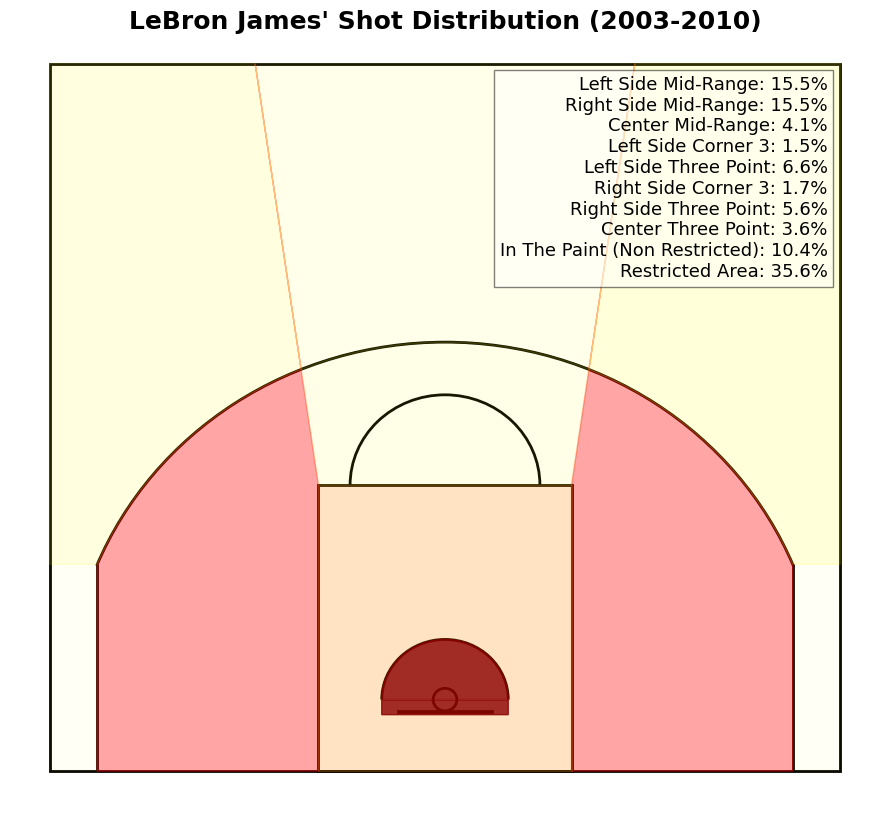

In [135]:
def plot_shot_distribution(distribution, alpha, title):
    # Calculate colors and opacities
    colore_opacita = color_and_opacity(distribution, alpha)

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(9,8.25))

    # Plot the court
    draw_court()

    # Plot the areas
    areas = create_polygons()

    #fill the areas with the corresponding color and opacity
    for area in areas:
        plt.fill(*areas[area].exterior.xy, color=colore_opacita[area][0], alpha=colore_opacita[area][1])

    plt.xlim(-275, 275)
    plt.ylim(-70, 440)
    plt.axis('off')

    plt.title(title, fontsize=18, fontweight='bold')

    # Add a legend box with shot distribution information
    text = '\n'.join([f'{area}: {distribution[area]:.1f}%' for area in distribution.keys()])
    plt.text(0.94, 0.95, text, fontsize=13, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, bbox=dict(edgecolor='black', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

# show the shot distribution for cavs1
plot_shot_distribution(distribution_cavs1, alpha=1, title='LeBron James\' Shot Distribution (2003-2010)')


At this stage, we've successfully created a heatmap illustrating LeBron James' shot distribution during his initial stint with the Cleveland Cavaliers. This heatmap visually displays the frequency of shot attempts across various zones on the basketball court, offering valuable insights into LeBron's shot selection during that period. Our next objective is to replicate this process for each distinct phase of LeBron's career in the NBA. This comprehensive approach will allow us to compare and analyze his shot distributions over time, revealing any significant changes or patterns in his shooting tendencies throughout his career.
To get a better undestanding of the evolution of LeBron's shot selection, we will plot all the eras in a single graph.

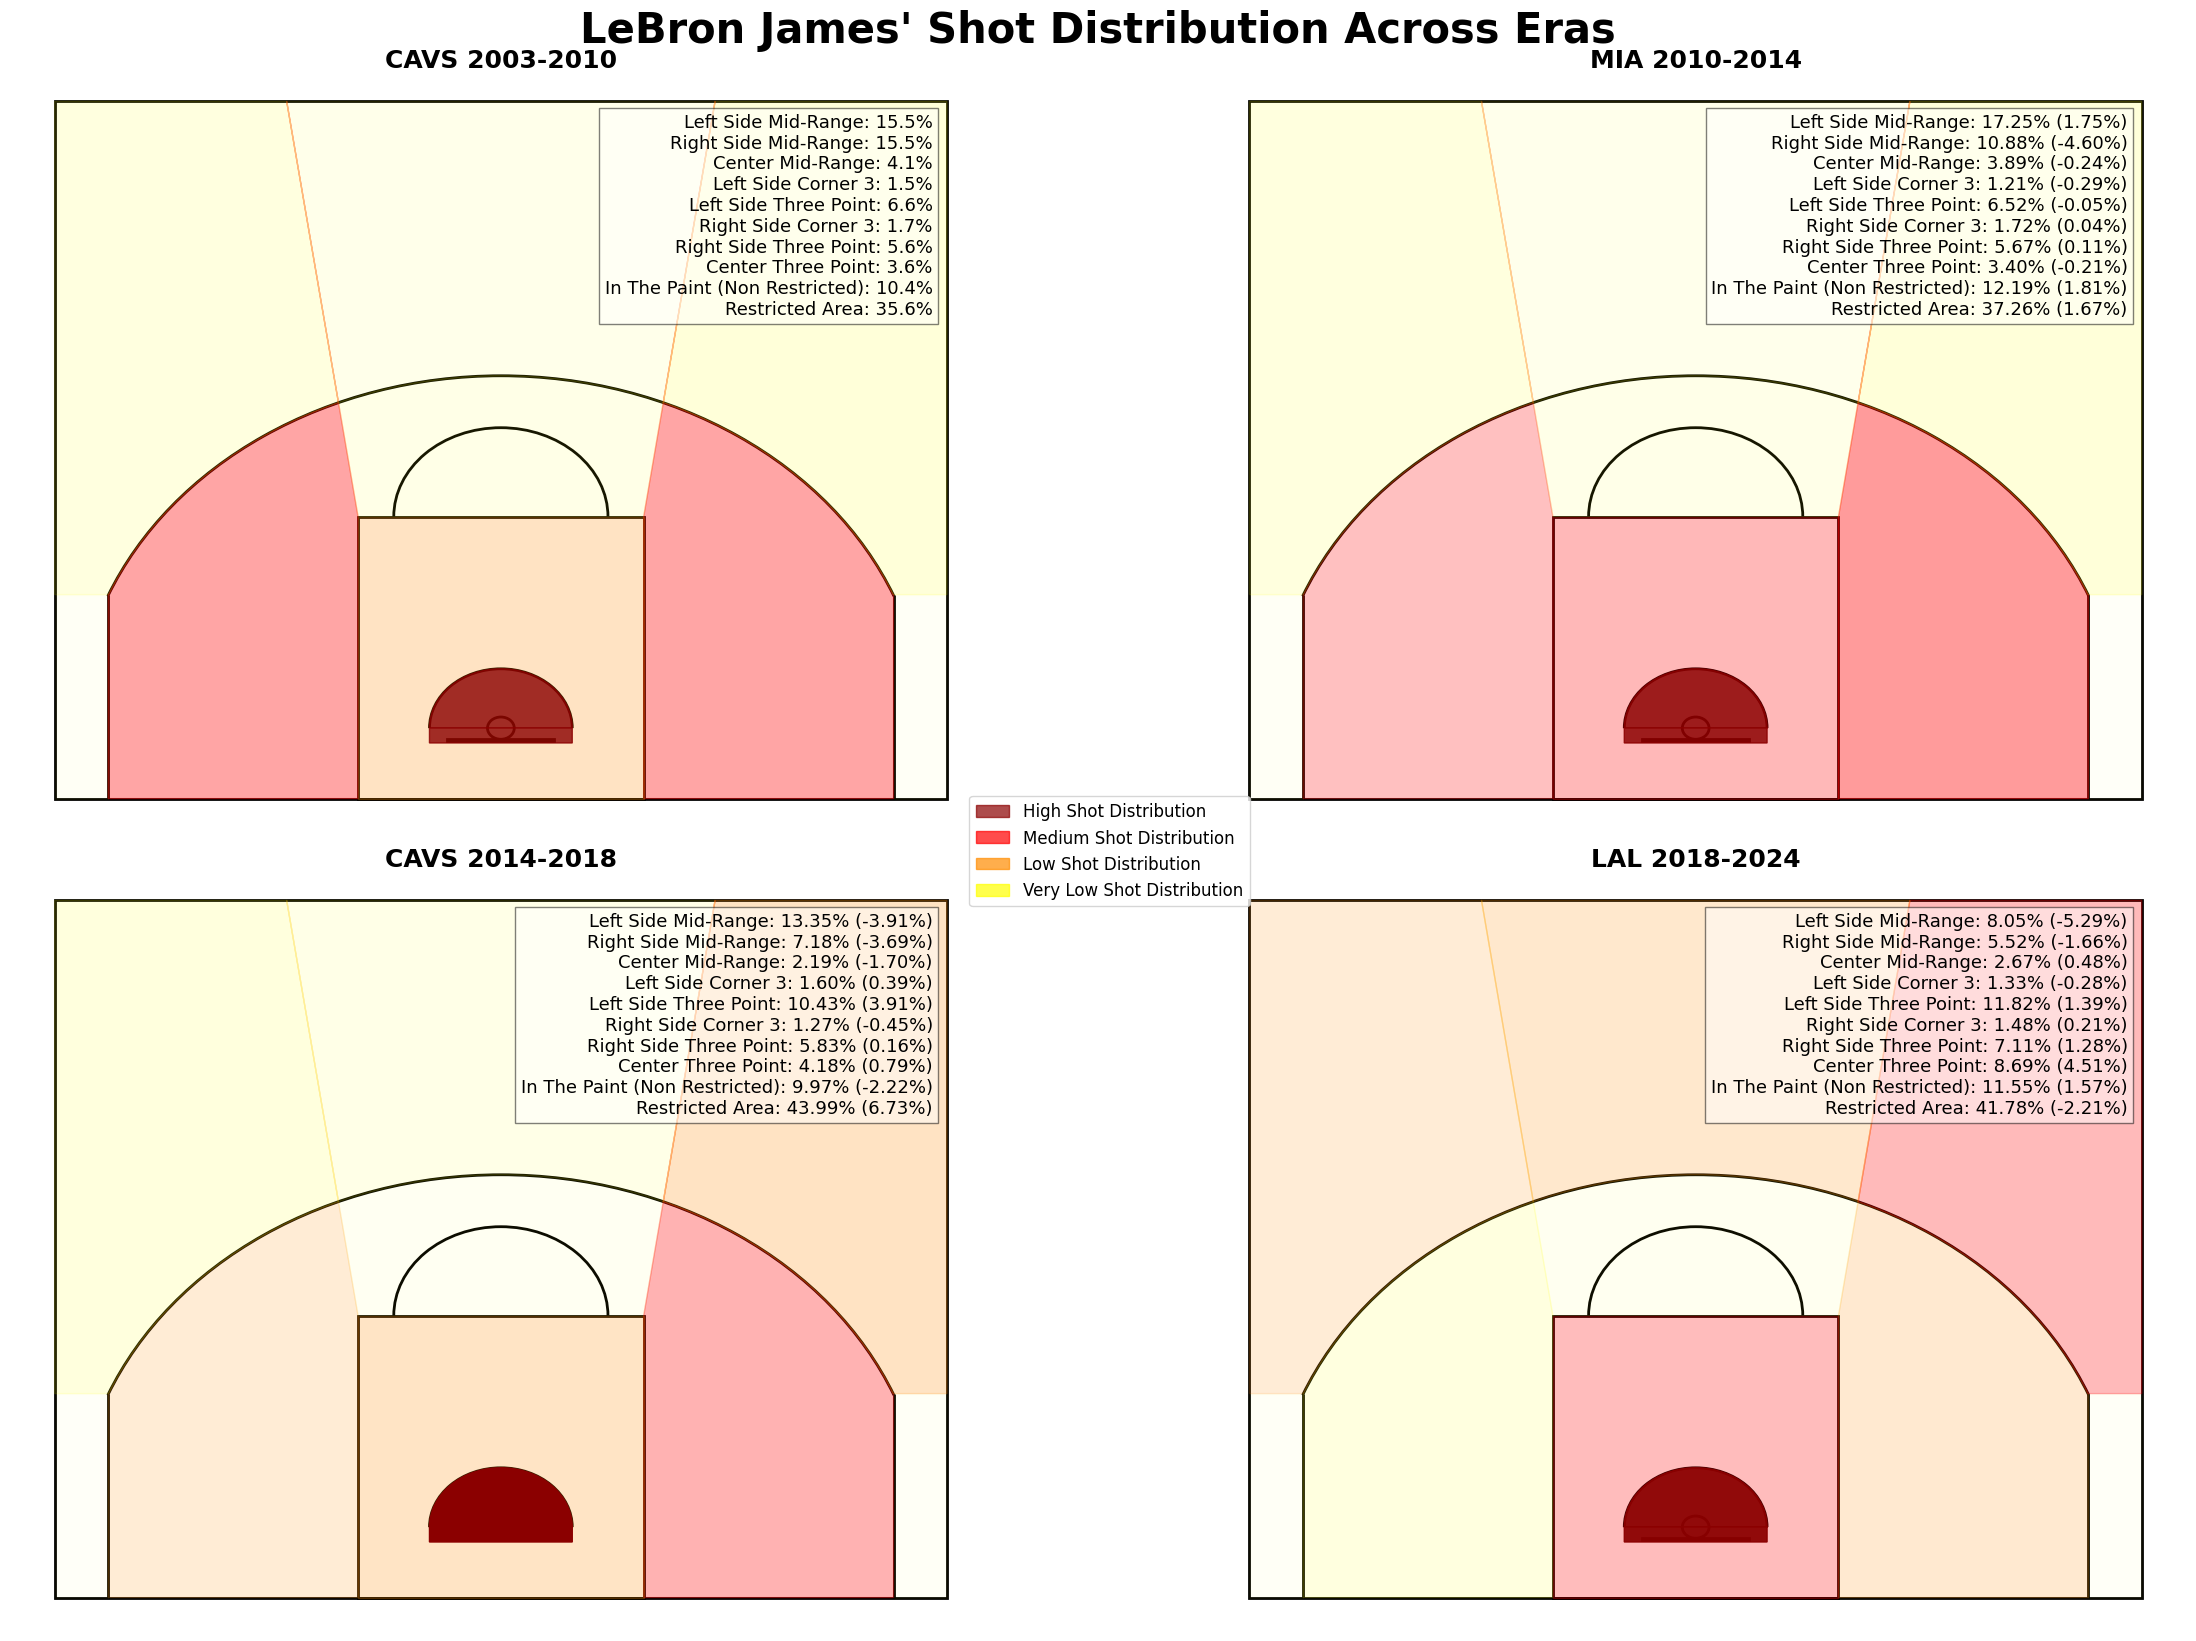

In [136]:
# generic function to plot the shot distribution for each era
# Parameters: ax (Axes): The Axes object to draw the plot on.
#             title (str): The title of the plot.
#             color_opacity (dict): A dictionary mapping each area to a list containing the color and opacity values.
# Returns: None
def draw_and_fill(ax, title, color_opacity):
    draw_court(ax)
    areas = create_polygons()
    for area in areas:
        ax.fill(*areas[area].exterior.xy, color=color_opacity[area][0], alpha=color_opacity[area][1])
    ax.set_xlim(-275, 275)
    ax.set_ylim(-70, 440)
    ax.axis('off')
    ax.set_title(title, fontsize=18, fontweight='bold')

# generic function to add the legend box with shot distribution information
# Parameters: ax (Axes): The Axes object to draw the plot on.
#             distribution (dict): A dictionary mapping each area to the percentage of shots attempted in that area.
#             reference_distribution (dict): A dictionary of the previous era's shot distribution. If provided, the legend will
#                                           show the percentage of shots attempted in each area and the difference from the previous era,
#                                           otherwise it will show only the percentage of shots attempted.
def add_legend(ax, distribution, reference_distribution=None):
    if reference_distribution is None:
        text = '\n'.join([f'{area}: {distribution[area]:.1f}%' for area in distribution.keys()])
    else:
        discards = {area: round(distribution[area] - reference_distribution[area], 2) for area in distribution.keys()}
        text = '\n'.join([f'{area}: {distribution[area]:.2f}% ({discards[area]:.2f}%)' for area in distribution.keys()])
    ax.text(0.94, 0.95, text, fontsize=13, verticalalignment='top', horizontalalignment='right', 
            transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.5))

# Set the size of the plot

#data used to mantain the correct ratio between width and height
W_subplots = 12  # Subplots width
H_subplots = 11  # Subplots height

# Actual size of the subplot
#Using this size because of slide presentation
subplot_width = 9
subplot_height = H_subplots * (subplot_width / W_subplots)

# Total size of the figure
fig_width = 2 * subplot_width + 6
fig_height = subplot_height * 2 + 0.2

#Set plot size
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))
# set width and height between subplots
plt.subplots_adjust(wspace=6)

# Draw and fill the court for each era
draw_and_fill(axs[0, 0], 'CAVS 2003-2010', color_and_opacity(distribution_cavs1, 1))
draw_and_fill(axs[0, 1], 'MIA 2010-2014', color_and_opacity(distribution_mia, 1))
draw_and_fill(axs[1, 0], 'CAVS 2014-2018', color_and_opacity(distribution_cavs2, 1))
draw_and_fill(axs[1, 1], 'LAL 2018-2024', color_and_opacity(distribution_lal, 1))

# Add the legend box with shot distribution information for each era
add_legend(axs[0, 0], distribution_cavs1)
add_legend(axs[0, 1], distribution_mia, distribution_cavs1)
add_legend(axs[1, 0], distribution_cavs2, distribution_mia)
add_legend(axs[1, 1], distribution_lal, distribution_cavs2)

#Add Title
fig.suptitle('LeBron James\' Shot Distribution Across Eras', fontsize=30, fontweight='bold', x=0.54)


# Create custom legend handles
legend_handles = [
    patches.Patch(color='darkred', alpha=0.7, label='High Shot Distribution'),
    patches.Patch(color='red', alpha=0.7, label='Medium Shot Distribution'),
    patches.Patch(color='darkorange', alpha=0.7, label='Low Shot Distribution'),
    patches.Patch(color='yellow', alpha=0.7, label='Very Low Shot Distribution')
]

# Add the custom legend to the figure
#params are set manually to fit the legend in the best way
fig.legend(handles=legend_handles, loc='center', fontsize=12, bbox_to_anchor=(0.545, 0.476))

plt.tight_layout()
plt.show()


To conclude this part of the analysis, we will compare the shot distribution for each era side by side to visualize how LeBron's shot selection has evolved over the years. We'll achieve this by plotting a scatter plot of the shot distribution for each era, allowing us to observe the changes in his shot selection over time.

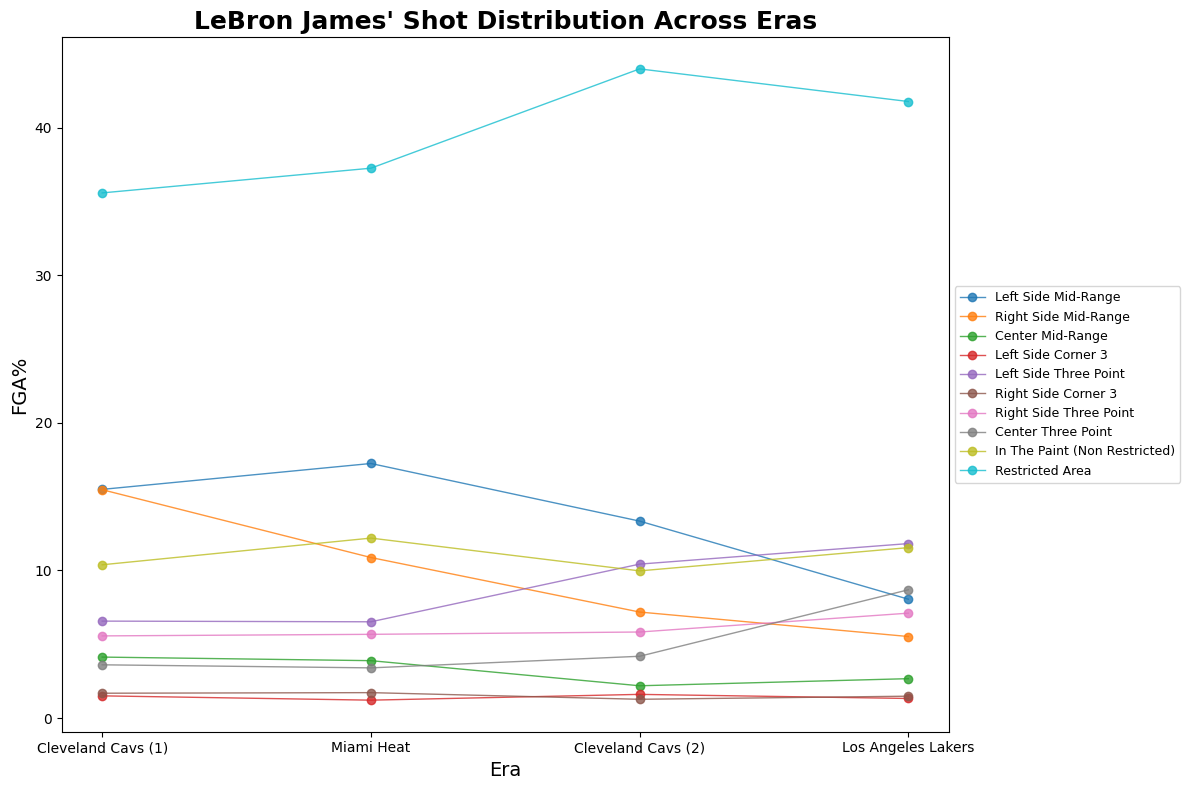

In [137]:
# Define shot distribution lists for each area
areas = [
    'Left Side Mid-Range', 'Right Side Mid-Range', 'Center Mid-Range',
    'Left Side Corner 3', 'Left Side Three Point', 'Right Side Corner 3',
    'Right Side Three Point', 'Center Three Point',
    'In The Paint (Non Restricted)', 'Restricted Area'
]

# Initialize empty lists for each area
area_distributions = {area: [] for area in areas}

# Append the values to the lists
for era in [distribution_cavs1, distribution_mia, distribution_cavs2, distribution_lal]:
    for area in areas:
        area_distributions[area].append(era[area])

# Set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data for each area
for area in areas:
    plt.plot(eras_label, area_distributions[area], marker='o', label=area, linestyle='solid', linewidth=1, alpha=0.8)

# Add labels and title
plt.xlabel('Era', fontsize=14)
plt.ylabel('FGA%', fontsize=14)
plt.title('LeBron James\' Shot Distribution Across Eras', fontsize=18, fontweight='bold')

# Add a legend
plt.legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


Since this representation doesn't significantly enhance the analysis, we'll move on to conclude this part without further discussion about the plot.

### Observations

During the early stages of his career, LeBron James exhibited a strong preference for midrange shots, demonstrating his ability to dominate both inside the paint and from medium distances. Throughout his tenure with the Cleveland Cavaliers and later with the Miami Heat, LeBron continued to prioritize shots close to the basket, utilizing his physical strength to penetrate effectively and score inside, while also taking a notable number of midrange shots.

During this period, LeBron sparingly attempted three-pointers, typically reserving them for critical moments. Upon joining the Miami Heat, a distinct tendency towards the left side of the court became increasingly evident.

Upon returning to the Cleveland Cavaliers for his second stint, LeBron underwent a noticeable shift in his shot selection. He began to increase his three-point attempts, especially from the left wing, showcasing his willingness to expand his shooting range and adapt to the evolving dynamics of the NBA. This adjustment coincided with a slight decrease in midrange shots, underscoring LeBron's strategic refinement aimed at maximizing his scoring efficiency.

During this phase of his career, LeBron was at his physical peak, enabling him to dominate in the paint, where he attempted nearly 44% of his shots, while also posing a significant threat from beyond the three-point line. His focus on left wing three-pointers increased by 3.18% compared to his time in Miami, highlighting his evolving versatility as a scorer.

In his recent experiences with the Los Angeles Lakers, LeBron has continued to refine his shot selection, showing a notable increase in three-point attempts from the right wing. This adjustment suggests a deliberate strategy to diversify his scoring options and maintain a balanced offensive approach. Despite a slight decrease in shots from the restricted area, LeBron's overall shot distribution remains well-rounded, emphasizing his adaptability and skillful shot selection.

Another intriguing observation is the decline in midrange shots over the years, aligning with the league-wide trend towards three-point shooting and efficient scoring strategies. LeBron's midrange shot attempts have decreased significantly over his career. Initially, he took 15.5% of his shots from midrange. In recent seasons, this has shifted markedly, with only 8.05% from the left side and 5.52% from the right side, highlighting his adaptation to modern NBA playstyles.


# Efficiency

## Shooting Efficiency Analysis of LeBron's Career

After examining LeBron's shot selection over the years, let's turn our attention to his shooting efficiency. In this section, we'll analyze LeBron's shooting percentages from various areas of the court and compare them across different eras to see how his efficiency has evolved.

The dataset described earlier includes information about the outcome of each shot attempt, indicating whether the shot was made or missed. Using this data, we can calculate LeBron's shooting percentages from different areas of the court and analyze how they have changed over time. Specifically, we will calculate the following efficiencies:

- Field Goal Percentage (FG%)
- 3-Point Field Goal Percentage (3P%)
- Effective Field Goal Percentage (eFG%)

To conduct our analysis, we'll define the following function:

### Shooting Efficiency
This function takes the dataset and the eras dictionary as inputs, returning a DataFrame that contains LeBron's shooting percentages from each area of the court for each era.

In [138]:
#Shooting Efficiency

#Function to calculate the shooting efficiency for each area
#Parameters: data (DataFrame): The dataset containing shot data.
#            seasons (list of strings): List of seasons to filter the dataset.
#Returns: dict: A dictionary mapping each area to the shooting efficiency in that area.

def shooting_efficiency(data, seasons):

    #Filter the data by the given seasons

    data = data[data.index.get_level_values('Season').isin(seasons)]

    #Get the total number of shots attempted for each area

    attemps = shots(data)

    #Get the total number of shots made for each area
    #let's use the same function to calculate the number of shots made for each area
    #first we have to filter the data by the shots made

    data = data[data.FG == 1]

    made = shots(data)

    #Create a dictionary with the shooting efficiency for each area
    efficiency = {area: made[area] / attemps[area] * 100 for area in attemps}

    return efficiency


At first glance, a box plot seems like an effective way to visualize LeBron's shooting efficiency across different areas. Therefore, we'll create a box plot to illustrate his shooting efficiency during his tenure with the Cleveland Cavaliers from 2003-2004 to 2009-2010. This will help us grasp the distribution and variability of his shooting performance during this period.

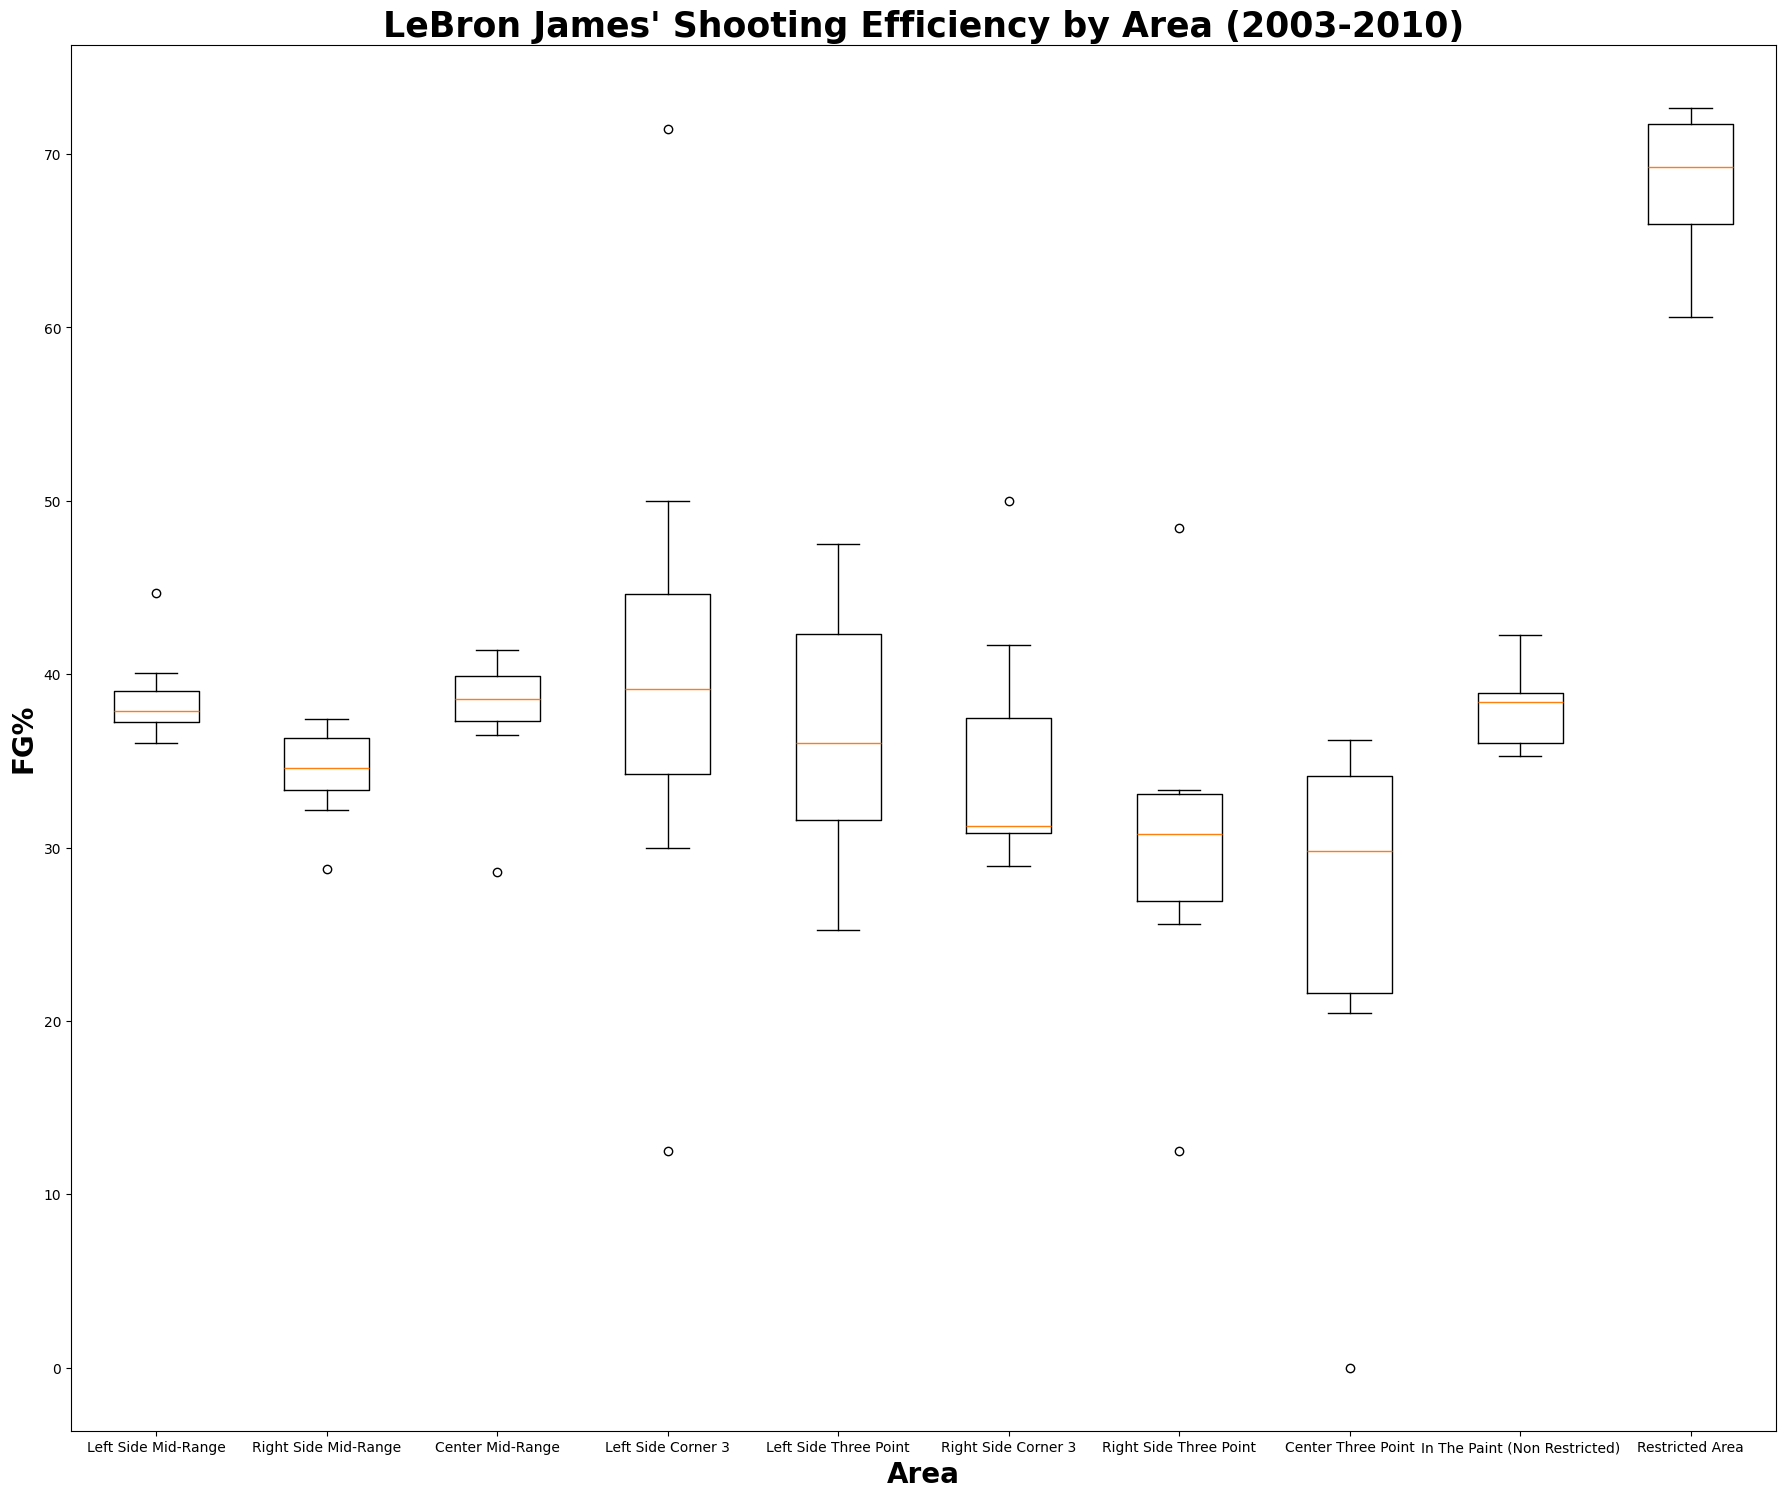

In [139]:
# Clear lists to ensure they are empty
Left_Side_Mid_Range.clear()
Right_Side_Mid_Range.clear()
Center_Mid_Range.clear()
Left_Side_Corner_3.clear()
Left_Side_Three_Point.clear()
Right_Side_Corner_3.clear()
Right_Side_Three_Point.clear()
Center_Three_Point.clear()
In_The_Paint_Non_Restricted.clear()
Restricted_Area.clear()

# Initialize a dictionary to hold efficiency data
efficiency_data = {
    'Left Side Mid-Range': Left_Side_Mid_Range,
    'Right Side Mid-Range': Right_Side_Mid_Range,
    'Center Mid-Range': Center_Mid_Range,
    'Left Side Corner 3': Left_Side_Corner_3,
    'Left Side Three Point': Left_Side_Three_Point,
    'Right Side Corner 3': Right_Side_Corner_3,
    'Right Side Three Point': Right_Side_Three_Point,
    'Center Three Point': Center_Three_Point,
    'In The Paint (Non Restricted)': In_The_Paint_Non_Restricted,
    'Restricted Area': Restricted_Area
}

# Iterate over seasons and calculate efficiency for each area
for season in cavs_1:
    efficiency = shooting_efficiency(df_shots, [season])
    for area in efficiency_data:
        efficiency_data[area].append(efficiency[area])

# Set the size of the plot
fig, ax = plt.subplots(figsize=(22, 18))

# Plot the data as a boxplot
plt.boxplot(efficiency_data.values(), labels=efficiency_data.keys())

# Add labels and title
plt.xlabel('Area', fontsize=20, fontweight='bold')
plt.ylabel('FG%', fontsize=20, fontweight='bold')
plt.title('LeBron James\' Shooting Efficiency by Area (2003-2010)', fontsize=25, fontweight='bold')

plt.show()


To be objective, this type of plot does not clearly illustrate LeBron's shooting efficiency due to the multitude of areas it covers. However, it does highlight a significant trend: LeBron shows inconsistency in his three-point shooting, evident from several outliers in his shooting efficiency. This aligns with the understanding that LeBron is not known for exceptional three-point accuracy but rather for making crucial shots when needed. Further analysis on this aspect will follow later in the study.

A more insightful view of LeBron James' shooting efficiency evolution can be achieved by plotting a line graph depicting his shooting percentages from various distances around the hoop. Specifically, for each era, we will plot two lines: one for shots taken from the left side and another for shots from the right side. This approach promises a more detailed and informative analysis of LeBron's shooting efficiency over the years.

To facilitate this analysis, we will utilize the following function:

### Shooting Efficiency by Distance

This function takes a dataframe containing a player's shot attempts and outcomes, along with a list of seasons, and returns a dataframe that calculates the shooting efficiency of the player for each season.

In [140]:
#Shooting Efficiency by Distance

#Function to calculate the shooting efficiency for each distance
#Parameters: data (DataFrame): The dataset containing shot data.
#            seasons (list of strings): List of seasons to filter the dataset.
#Returns: list: A list containing the shooting efficiency for each distance.
def shooting_efficiency_distance(data, seasons):
    efficiency = []
    data = data[data.index.get_level_values('Season').isin(seasons)]

    for i in range(0, 30):
        
        attempts = data[data.Distance == i].shape[0]
        made = data[(data.Distance == i) & (data.FG == 1)].shape[0]
        efficiency.append(made / attempts * 100)

    return efficiency

In [141]:
#some useful constants that will be used to create the distance ranges

efficiency_l = []
efficiency_r = []

distances = np.arange(0, 30)

Once all necessary functions are defined, we can proceed to plot LeBron James' shooting efficiency from various distances around the hoop. To begin, let's establish a generic function that will visualize shooting efficiency for any player from different distances around the hoop.

### Plot Distance Ranges
This function is crafted to visually delineate different areas of the basketball court according to their distance from the hoop. It takes an axis object as input and enriches it by plotting the various distance ranges on the court.


In [142]:
# Define distance ranges and corresponding colors/texts
distances_ranges = np.array([ (0, 3), (3, 15), (8, 23.5), (23.5, 31), (22, 25)])

colors_ranges = np.array(['red', 'blue', 'green', 'purple', 'orange'])

colors_text = np.array(['Restricted Area', 'In The Paint (Non Restricted)', 'Mid-Range', 'Three Point', 'Corner Three'])

# Function to plot shot zones based on distance ranges

def plot_dist(ax):
    for i, (start, end) in enumerate(distances_ranges):
        ax.axvspan(start, end, color=colors_ranges[i], alpha=0.05)
        ax.text((start + end) / 2, 8, colors_text[i], fontsize=7, ha='center', color='black')



As an example, let's visualize LeBron James' shooting efficiency based on distance during his time with the Cleveland Cavaliers from 2003-2004 to 2009-2010.

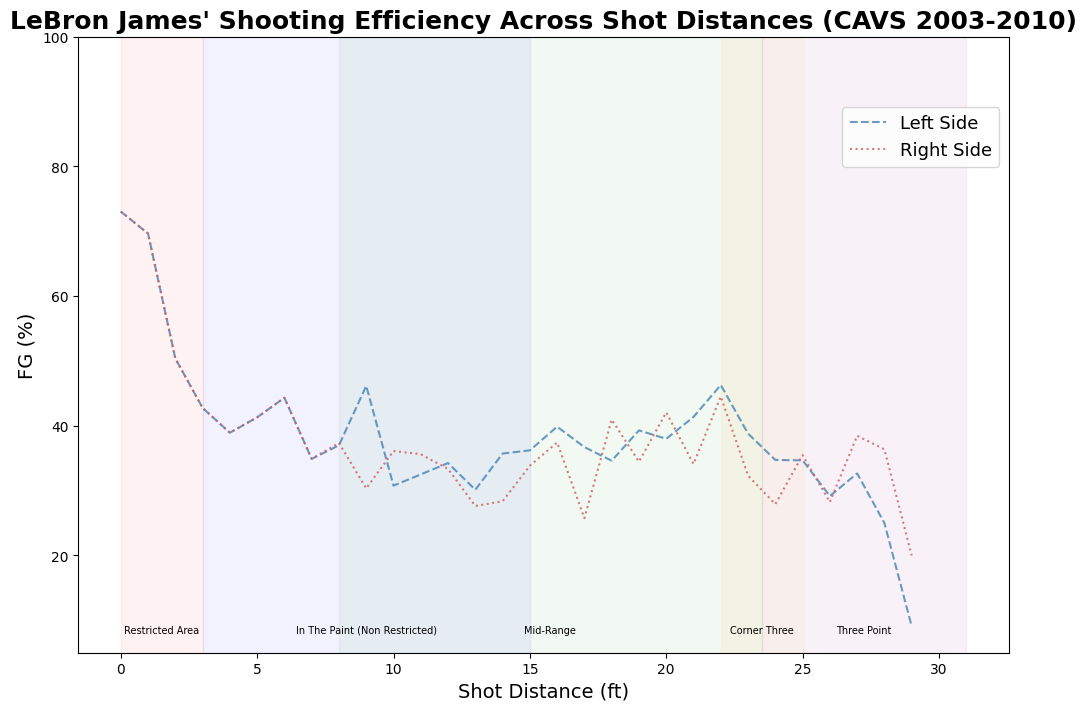

In [143]:
# scatter plot of correlation between shooting efficiency and shot distance
# plot a line for the left and one for the right side

df_l = df_shots[(df_shots.Area == 'Left Side(L)') | (df_shots.Area == 'Center(C)')]
df_r = df_shots[(df_shots.Area == 'Right Side(R)') | (df_shots.Area == 'Center(C)')]

#calculate the shooting efficiency for the left side
efficiency_l = shooting_efficiency_distance(df_l, cavs_1)

#calculate the shooting efficiency for the right side
efficiency_r = shooting_efficiency_distance(df_r, cavs_1)


#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

#plot the data
plt.plot(range(0, 30), efficiency_l, label='Left Side', color='steelblue', alpha=0.8, linestyle='dashed')
plt.plot(range(0, 30), efficiency_r, label='Right Side', color='indianred', alpha=0.8, linestyle='dotted')

#y axis limits
plt.ylim(5, 100)

#plot the distance ranges
plot_dist(ax)

#add labels and title
plt.xlabel('Shot Distance (ft)', fontsize=14)
plt.ylabel('FG (%)', fontsize=14)
plt.title('LeBron James\' Shooting Efficiency Across Shot Distances (CAVS 2003-2010)', fontsize=18, fontweight='bold')

#add legend
plt.legend( fontsize=13, loc='upper right', bbox_to_anchor=(1, 0.9))

plt.show()


Let's proceed to plot LeBron's shooting efficiency for each era side by side, illustrating how his shooting has evolved over the years. We will achieve this by creating a line graph where, for each era, we display the shooting efficiency from various distances around the hoop.

Once again, we will utilize a generic function to keep our code clean while plotting the shooting efficiency for four different eras.

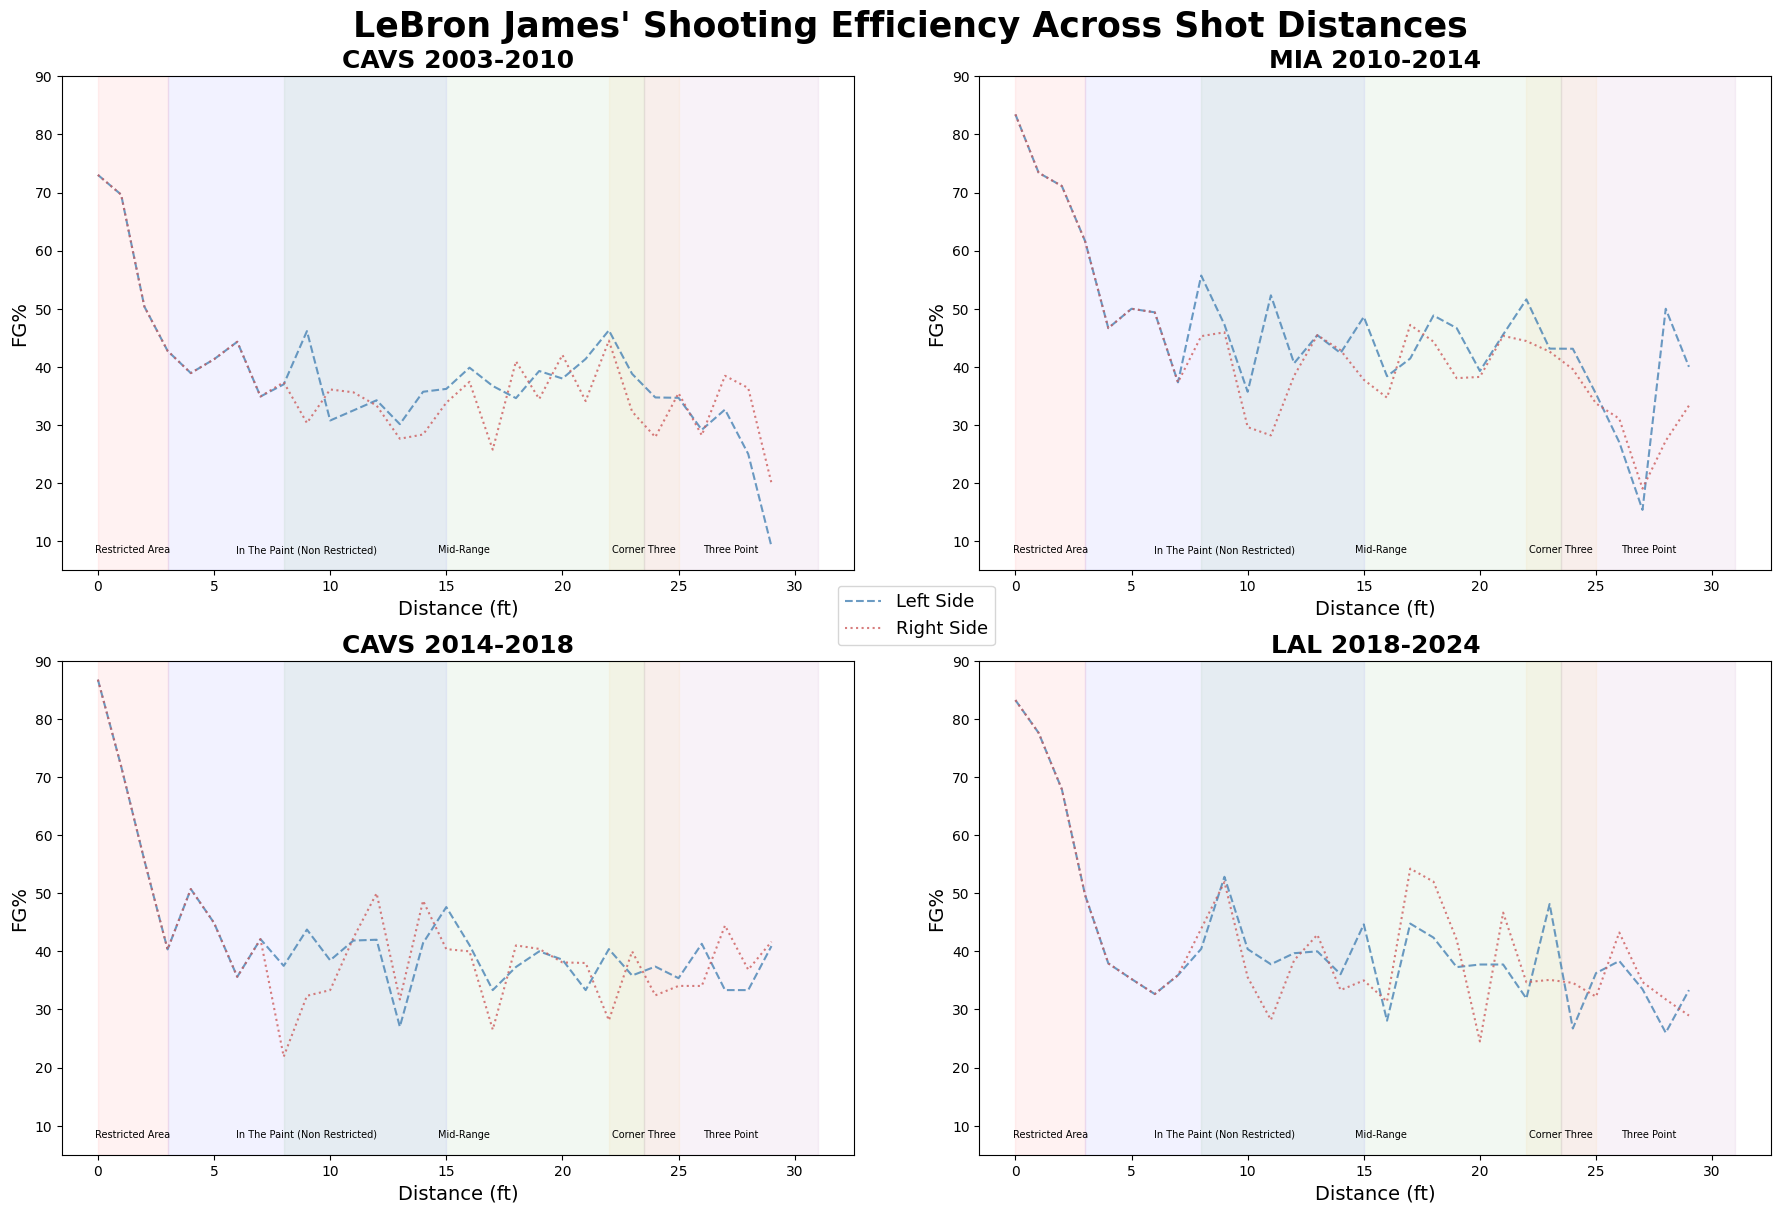

In [144]:
#Define a function to calculate and plot shooting efficiency
#Parameters: ax (Axes): The Axes object to draw the plot on.
#            title (str): The title of the plot.
#            seasons (list of strings): List of seasons to filter the dataset.
#            data (DataFrame): The dataset containing shot data.
def plot_efficiency(ax, title, seasons, data):
    df_l = data[(data.Area == 'Left Side(L)') | (data.Area == 'Center(C)')]
    df_r = data[(data.Area == 'Right Side(R)') | (data.Area == 'Center(C)')]

    efficiency_l = shooting_efficiency_distance(df_l, seasons)
    efficiency_r = shooting_efficiency_distance(df_r, seasons)

    ax.plot(range(0, 30), efficiency_l, label='Left Side', color='steelblue', alpha=0.8, linestyle='dashed')
    ax.plot(range(0, 30), efficiency_r, label='Right Side', color='indianred', alpha=0.8, linestyle='dotted')

    ax.set_ylim(5, 90)
    plot_dist(ax)
    ax.set_xlabel('Distance (ft)', fontsize=14)
    ax.set_ylabel('FG%', fontsize=14)
    ax.set_title(title, fontsize=18, fontweight='bold')

# Create the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(18.5, 12.33))

# Set width and height between subplots
plt.subplots_adjust(wspace=45, hspace=0.6)

# Plot the shooting efficiency for each era
plot_efficiency(axs[0, 0], 'CAVS 2003-2010', cavs_1, df_shots)
plot_efficiency(axs[0, 1], 'MIA 2010-2014', mia, df_shots)
plot_efficiency(axs[1, 0], 'CAVS 2014-2018', cavs_2, df_shots)
plot_efficiency(axs[1, 1], 'LAL 2018-2024', lal, df_shots)

# Add a legend
fig.legend(['Left Side', 'Right Side'], loc='upper center', fontsize=13, bbox_to_anchor=(0.503, 0.52), bbox_transform=plt.gcf().transFigure)

#Add a title
fig.suptitle('LeBron James\' Shooting Efficiency Across Shot Distances', fontsize=25, fontweight='bold')


plt.tight_layout()

plt.show()


To support our analysis, we can calculate the correlation between LeBron's shooting efficiency and the distances of his shots.

In [145]:
#This function takes the dataset and a list of seasons as inputs and returns the correlation coefficient between the shot distance and the shooting efficiency for each season.

#input data: DataFrame, list of strings
#output: float

def correlation_distance_efficiency(data, seasons):
    efficiency = []
    efficiency = shooting_efficiency_distance(data, seasons)
    distances = np.arange(0, 30)
    return np.corrcoef(distances, efficiency)[0, 1]

print(correlation_distance_efficiency(df_shots, cavs_1))
print(correlation_distance_efficiency(df_shots, mia))
print(correlation_distance_efficiency(df_shots, cavs_2))
print(correlation_distance_efficiency(df_shots, lal))


#correlazione negativa medio-forte tra distanza e efficienza di tiro

-0.6371182225693237
-0.7746830649191123
-0.5462013896049668
-0.5827765247306257



## Observations
LeBron James' shooting efficiency has evolved significantly throughout his career, highlighting his adaptability and continuous skill development. Analyzing his shooting percentages from different distances around the hoop provides valuable insights into his offensive growth and strategic adjustments.

During his initial tenure with the Cleveland Cavaliers (2003-2004 to 2009-2010), LeBron showed exceptional efficiency in the restricted area, consistently converting a high percentage of his shots. He also demonstrated solid midrange shooting, particularly from the left side of the court. However, his three-point shooting exhibited inconsistency and was relatively poor, with noticeable variability in accuracy from various distances. This trend is reinforced by the consistently negative correlations between shooting efficiency and distance (-0.637).

Upon joining the Miami Heat (2010-2011 to 2013-2014), LeBron's shooting efficiency improved across all areas, reflecting his growth as a scorer and enhanced offensive versatility. His three-point shooting notably became more reliable, especially from longer distances. This improvement was accompanied by enhanced midrange efficiency, particularly from the right side of the court and the restricted area. Despite these advancements, the correlation between shooting efficiency and distance remained negative during this period (-0.775).

Returning to the Cleveland Cavaliers (2014-2015 to 2017-2018) marked a notable shift in LeBron's shooting efficiency. There was a noticeable improvement, with his three-point accuracy stabilizing, particularly from the left wing. This enhancement in long-range shooting was paired with a slight decline in midrange efficiency, reflecting LeBron's strategic adjustments towards more efficient scoring strategies. The correlation between shooting efficiency and distance in this era shows a positive trend (-0.546), indicating greater consistency across different court areas compared to previous years.

Lastly, LeBron's time with the Los Angeles Lakers (2018-2019 to present) has been marked by heightened shooting variability from both sides of the court. This era has revealed inconsistencies in his shooting performance, influenced by factors such as age and an increased dependence on three-point attempts. LeBron has evolved into a self-made shooter, where consistency is not always guaranteed. Despite his development into a more proficient three-point shooter over time, his shooting efficiency still shows a slightly stronger negative correlation with distance during this Lakers era (-0.583).

### 3-Point Shooting Efficiency and Effective Field Goal Percentage Analysis

Based on the insights from the previously drawn boxplot, it's evident that LeBron James has encountered challenges with his three-point shooting efficiency, displaying significant variability in performance over the years.

To delve deeper into this analysis, we will track the evolution of LeBron's three-point shooting efficiency by creating a line graph that illustrates his performance across different eras. This visualization will help us identify trends and changes in his shooting efficiency over time.

Furthermore, another valuable metric to examine is LeBron's Effective Field Goal Percentage (eFG%) progression throughout his career. This metric provides a comprehensive assessment of his shooting efficiency by accounting for the added value of three-point shots. Analyzing LeBron's eFG% across various eras will provide valuable insights into his overall scoring efficiency and illuminate how it has evolved over the course of his career.

To graphically represent this analysis, we will use the following functions:

#### Shooting Efficiency by Season
This function calculates a player's shooting efficiency for each season based on the provided dataset. It returns a DataFrame containing the shooting efficiency for each season.

#### Calculate Effective Field Goal Percentage
This function calculates the Effective Field Goal Percentage (eFG%) for a player based on their shooting data. It takes the dataset as input and returns a DataFrame containing the eFG% for each season. The eFG% formula is defined as follows:

$$
  eFG\% = \frac{FGM + 0.5 * 3P\_made}{FGA}
$$


In [146]:
#shooting efficiency by season behind the arc

#This function takes the dataset and a list of seasons as inputs and returns a list of shooting percentages for each season

#input data: DataFrame
#output: list of floats

def shooting_efficiency_season(data, seasons):
    efficiency = []

    for season in seasons:
        attempts = data[data.index.get_level_values('Season') == season].shape[0]
        made = data[(data.index.get_level_values('Season') == season) & (data.FG == 1)].shape[0]
        efficiency.append(made / attempts * 100)

    return efficiency

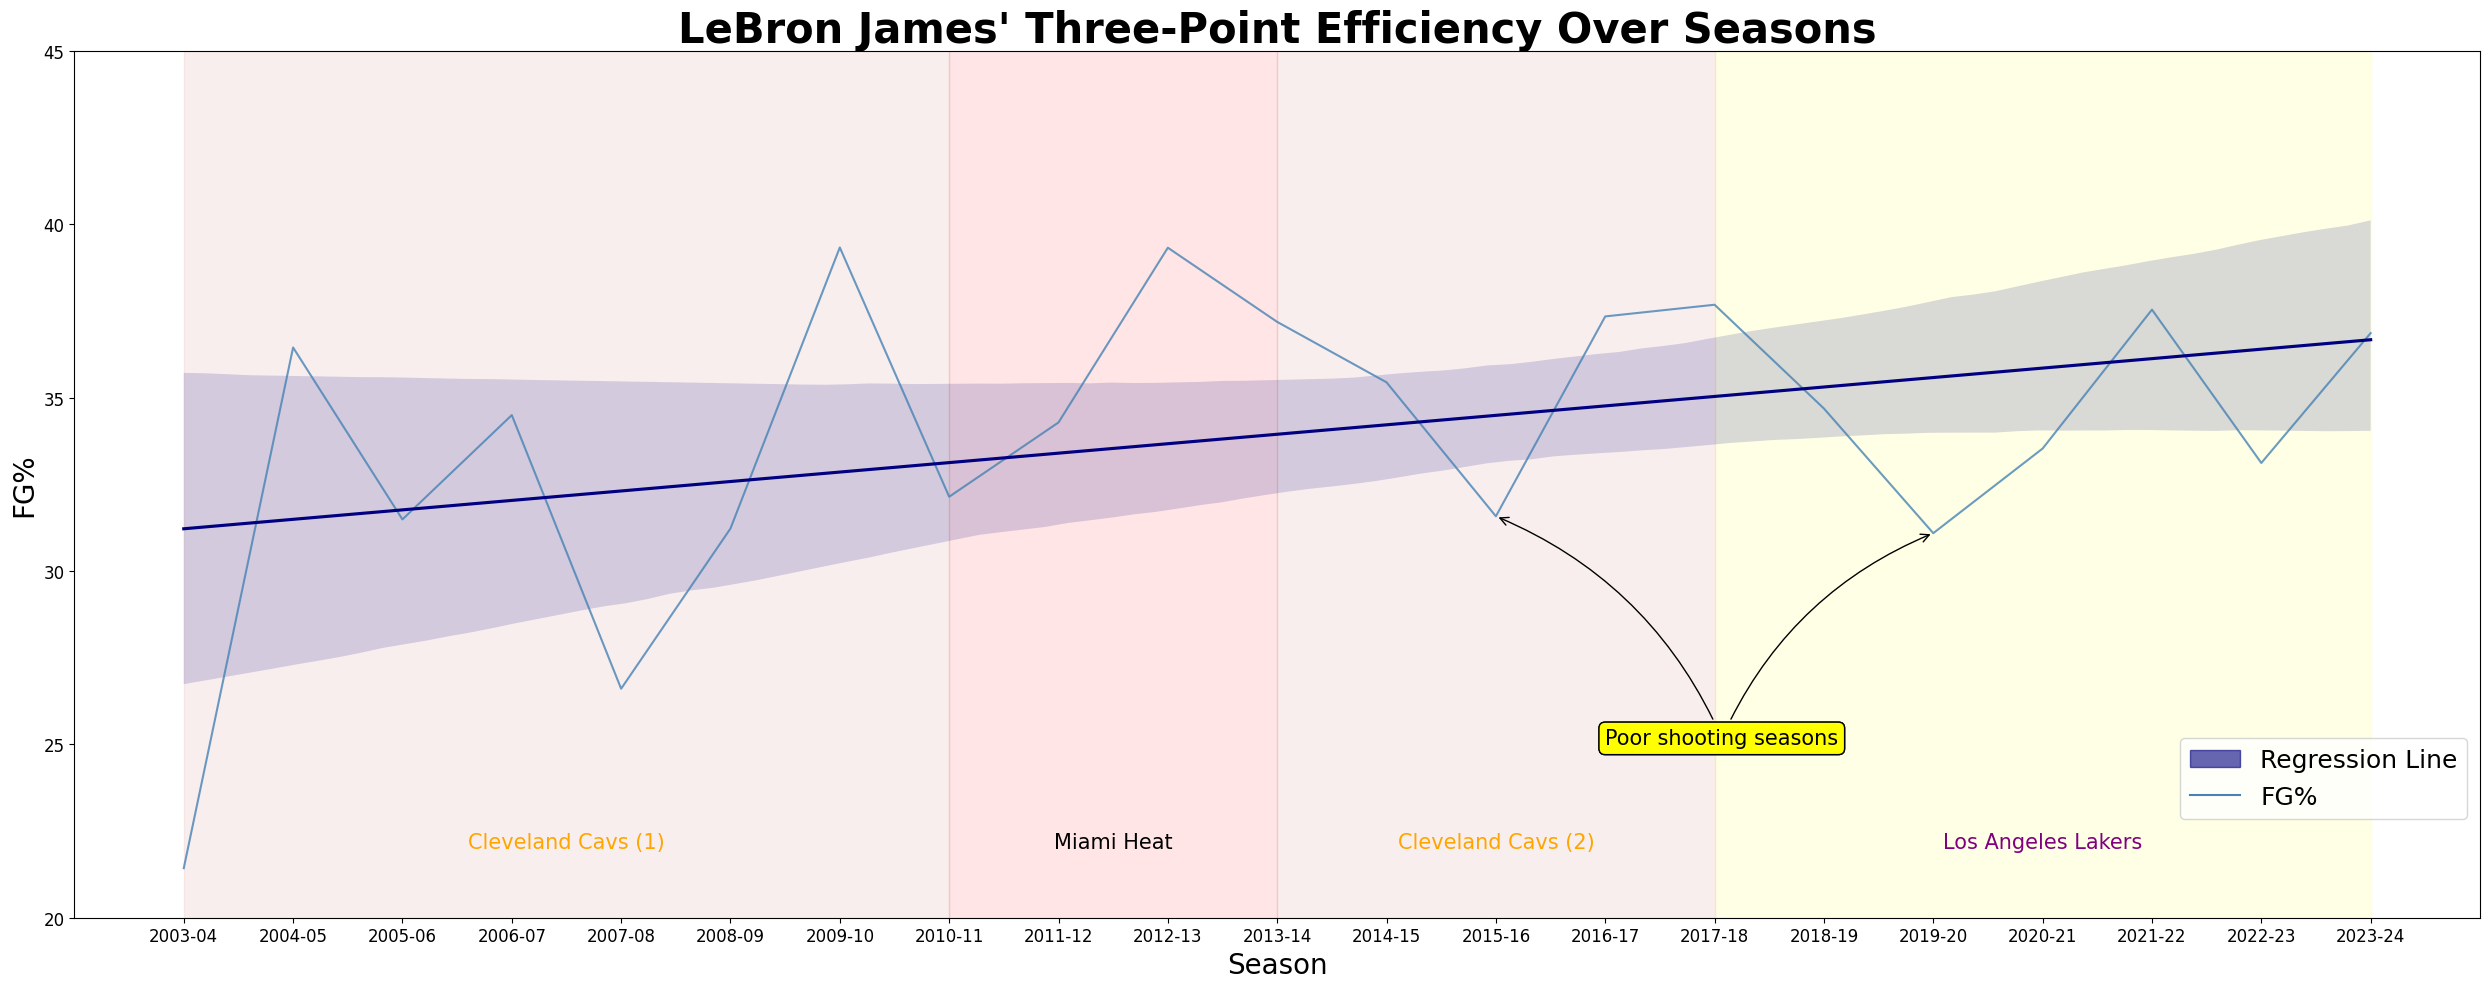

In [147]:
# Clear lists for shooting efficiency
efficiency_l.clear()
efficiency_r.clear()

# Create numeric seasons list
seasons_numeric = list(range(0, 21))

# Filter data for above the break 3 shots
df_threes = df_shots[df_shots.Zone == 'Above the Break 3']

# Calculate shooting efficiency for above the break 3 shots
efficiency = shooting_efficiency_season(df_threes, seasons)

# Define eras and their respective plot areas with colors and text
eras = [
    ('Cleveland Cavs (1)', 0, 7, 'indianred'),
    ('Miami Heat', 7, 10, 'red'),
    ('Cleveland Cavs (2)', 10, 14, 'indianred'),
    ('Los Angeles Lakers', 14, 20, 'yellow')
]
text_colors = ['orange', 'black', 'orange', 'purple']

# Set the size of the plot
fig, ax = plt.subplots(figsize=(25, 10))
plt.ylim(20, 50)

# Plot the data for three-point shooting efficiency
plt.plot(seasons, efficiency, label='Three Point', color='steelblue', alpha=0.8, linestyle='-')

#text size on axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Plot shaded areas and labels for each era
for (era, start, end, color), text_color in zip(eras, text_colors):
    plt.fill_between([start, end], 0, 100, color=color, alpha=0.1)
    plt.text((start + end) / 2, 22, era, fontsize=15, ha='center', color=text_color)

# Add labels and title
plt.xlabel('Season', fontsize=20)
plt.ylabel('FG%', fontsize=20)
plt.title('LeBron James\' Three-Point Efficiency Over Seasons', fontsize=30, fontweight='bold')


# Annotate poor shooting seasons
annotations = [
    {'text': 'Poor shooting seasons', 'xy': (12, efficiency[12]), 'xytext': (13, 25), 'rad': 0.2},
    {'text': 'Poor shooting seasons', 'xy': (16, efficiency[16]), 'xytext': (13, 25), 'rad': -0.2}
]

for annotation in annotations:
    plt.annotate(
        annotation['text'], xy=annotation['xy'], xytext=annotation['xytext'], fontsize=15,
        arrowprops=dict(arrowstyle="->", connectionstyle=f"arc3,rad={annotation['rad']}", color='black'),
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow')
    )

# Plot regression line using seaborn
sns.regplot(x=seasons_numeric, y=efficiency, scatter=False, ax=ax, line_kws={"color": "navy"})

#Add Legend for FG% and regression line
legend_handles = [
    patches.Patch(color='navy', label='Regression Line', alpha=0.6),
    Line2D([0], [0], color='steelblue', label='FG%')
    ]

ax.legend(handles=legend_handles, loc='lower right', fontsize=18, bbox_to_anchor=(1, 0.1))

#set lim
plt.ylim(20, 45)

plt.tight_layout()

plt.show()


In [148]:
#Effective Field Goal Percentage

#efg = fg + 0.5 * threes_made / attemps

#This function takes the dataset and a list of seasons as inputs and returns a list of effective field goal percentages for each season.

#input data: DataFrame, list of strings
#output: list of floats

def calculate_efg(data, seasons):
    efg = []

    for season in seasons:
        df_season = data[data.index.get_level_values('Season') == season]
        fg = df_season[df_season.FG == 1].shape[0]
        threes_made = df_season[(df_season.FG == 1) & (df_season.Zone == 'Above the Break 3')].shape[0]
        attemps = df_season.shape[0]
        efg.append((fg + 0.5 * threes_made) / attemps * 100)

    return efg

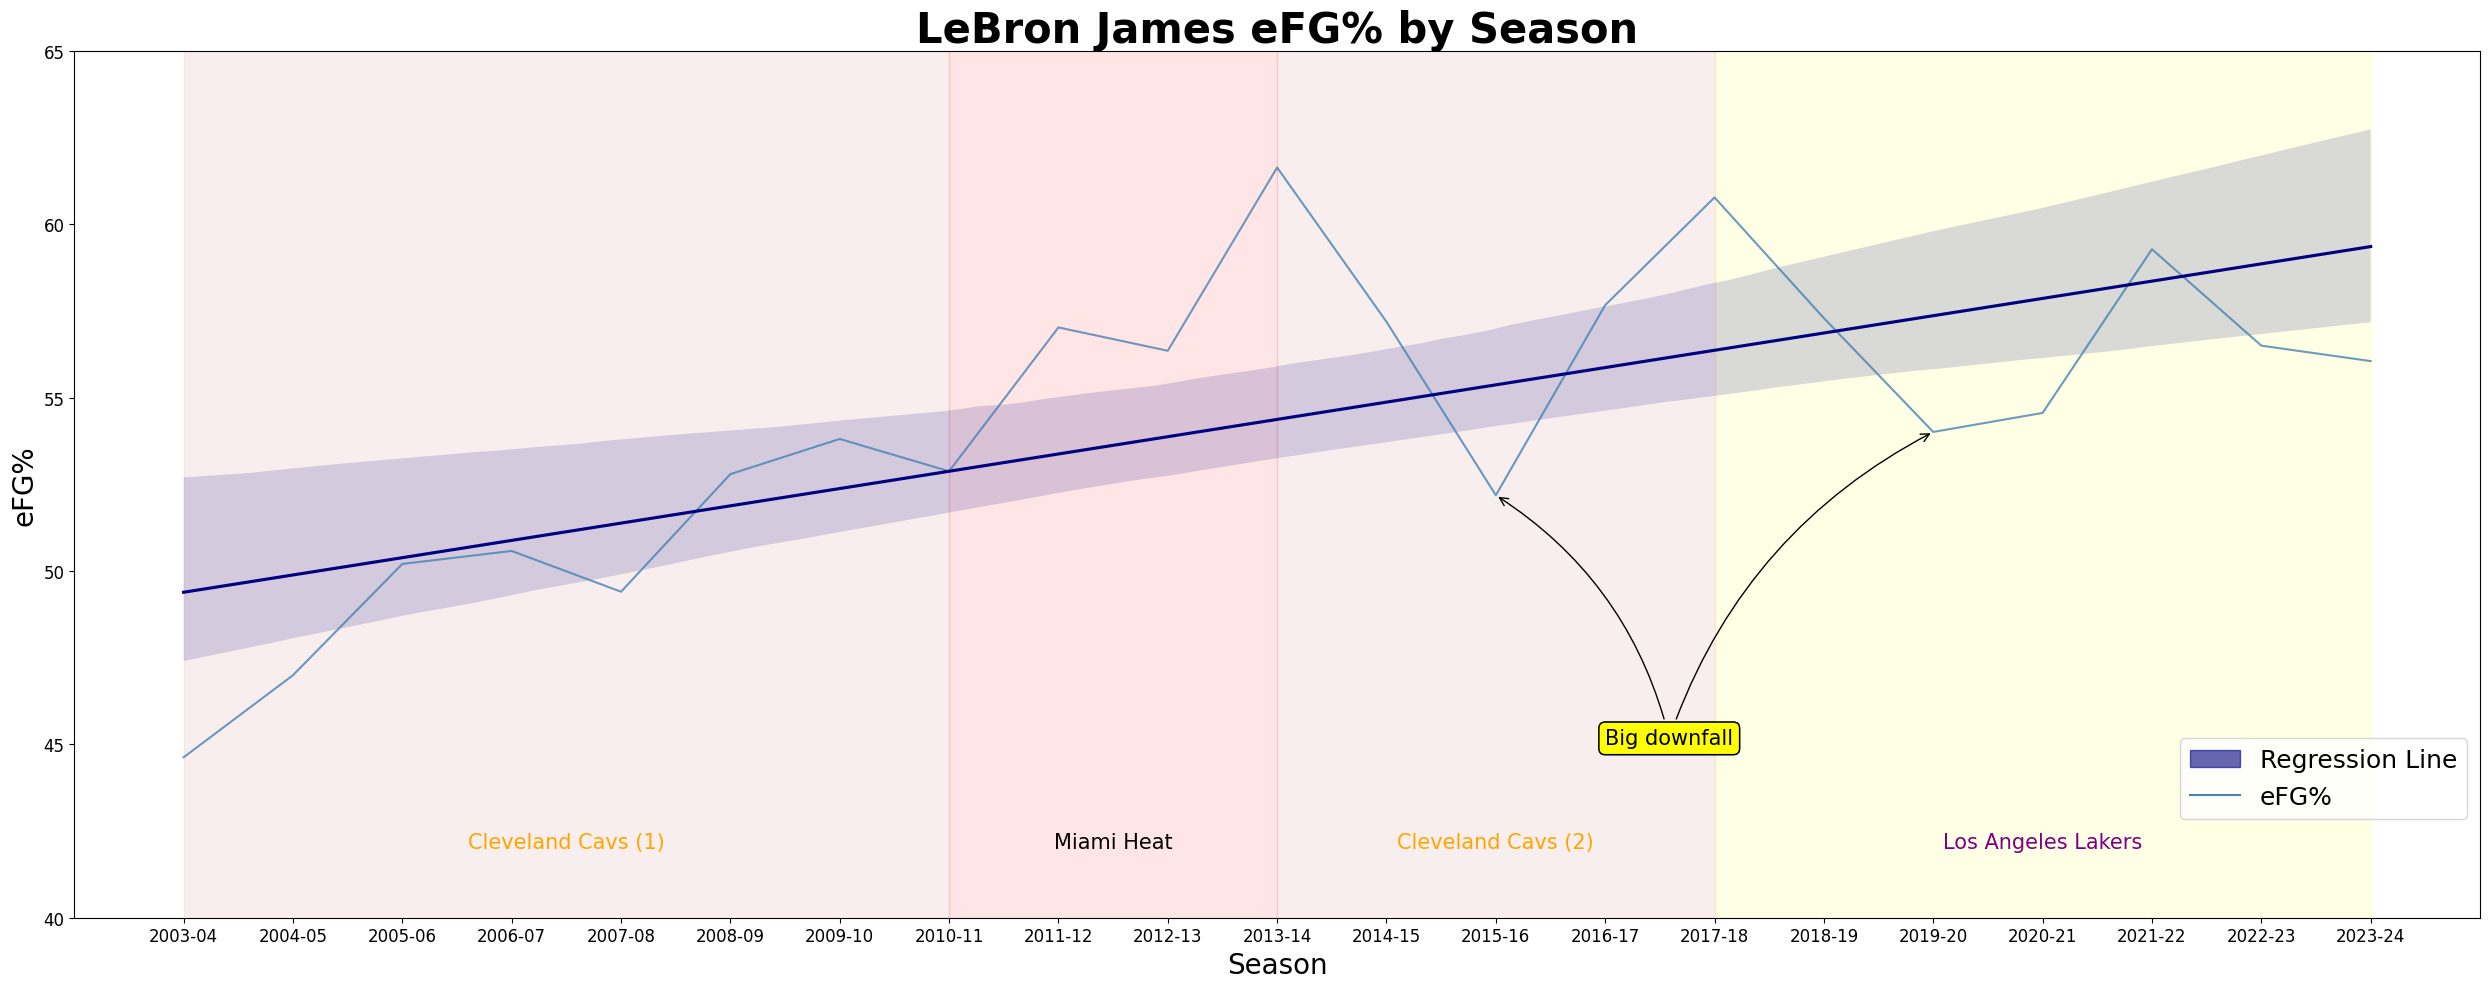

In [149]:
# Supponiamo che la funzione calculate_efg sia già definita e restituisca i dati necessari
efg = calculate_efg(df_shots, seasons)  # Utilizziamo range(0, 20) per rappresentare le stagioni

# Converti range(0, 20) in una lista di numeri interi
seasons_numeric = list(range(0, 21))

# Imposta la dimensione del grafico
fig, ax = plt.subplots(figsize=(25, 10))

# Limiti dell'asse y
plt.ylim(40, 75)

# Plot the data for effective field goal percentage
plt.plot(seasons, efg, label='Effective Field Goal Percentage', color='steelblue', alpha=0.8, linestyle='-')

#set the size of the text on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Define eras and their respective plot areas with colors and text
eras = [
    ('Cleveland Cavs (1)', 0, 7, 'indianred'),
    ('Miami Heat', 7, 10, 'red'),
    ('Cleveland Cavs (2)', 10, 14, 'indianred'),
    ('Los Angeles Lakers', 14, 20, 'yellow')
]
text_colors = ['orange', 'black', 'orange', 'purple']

# Plot shaded areas and labels for each era
for (era, start, end, color), text_color in zip(eras, text_colors):
    plt.fill_between([start, end], 0, 100, color=color, alpha=0.1)
    plt.text((start + end) / 2, 42, era, fontsize=15, ha='center', color=text_color)


# Annotate poor shooting seasons
annotations = [
    {'text': 'Big downfall', 'xy': (12, efg[12]), 'xytext': (13, 45), 'rad': 0.2},
    {'text': 'Big downfall', 'xy': (16, efg[16]), 'xytext': (13, 45), 'rad': -0.2}
]

for annotation in annotations:
    plt.annotate(
        annotation['text'], xy=annotation['xy'], xytext=annotation['xytext'], fontsize=15,
        arrowprops=dict(arrowstyle="->", connectionstyle=f"arc3,rad={annotation['rad']}", color='k'),
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow')
    )

# Plot regression line using seaborn
sns.regplot(x=seasons_numeric, y=efg, scatter=False, ax=ax, line_kws={"color": "navy"})

#Add Legend for efg% and regression line
legend_handles = [
    patches.Patch(color='navy', label='Regression Line', alpha=0.6),
    Line2D([0], [0], color='steelblue', label='eFG%')
    ]

ax.legend(handles=legend_handles, loc='lower right', fontsize=18, bbox_to_anchor=(1, 0.1))


#set lim
plt.ylim(40, 65)

# Add labels and title
plt.xlabel('Season', fontsize=20)
plt.ylabel('eFG%', fontsize=20)
plt.title('LeBron James eFG% by Season', fontsize=30, fontweight='bold')

plt.tight_layout()

plt.show()


In [150]:
#calculete mean usage for each era

#This function takes the dataset and a list of seasons as inputs and returns the mean usage rate for each season.

#input data: DataFrame, list of strings
#output: list of floats

def calculate_usage(data, seasons):
    usage = 0

    for season in seasons:
        usage = data[data.index.get_level_values('Season') == season]['USG'].mean()

    return usage

print(calculate_usage(df_advanced, cavs_1))
print(calculate_usage(df_advanced, mia))
print(calculate_usage(df_advanced, cavs_2))
print(calculate_usage(df_advanced, lal))


33.5
31.0
31.6
29.2


## Observations

The graphs clearly illustrate LeBron's significant improvement in three-point shooting efficiency over the years, particularly evident in the most recent eras. This improvement is mirrored in his Effective Field Goal Percentage (eFG%), which has shown a positive trend, indicating enhanced scoring efficiency. However, his shooting percentage exhibits notable inconsistency, with numerous outliers in shooting efficiency. This reflects LeBron's evolution as a shooter, having developed his skills over the course of his career rather than being a natural three-point specialist.

The eFG% plot highlights LeBron's peak performance during his tenure with the Miami Heat, where he maintained a consistently high eFG% over consecutive seasons. This aligns with the Heat's dominant roster and strong coaching staff during that period, enabling LeBron to perform at his peak (statisticly).

Upon returning to the Cleveland Cavaliers, LeBron experienced a slight decrease in his eFG%, which aligned with the team not possessing the same level of strength as the Miami Heat. This transition necessitated LeBron to assume a greater offensive burden, resulting in defenses adapting to contain him. Nevertheless, his eFG% remained relatively high, underscoring that this period represented the real peak in his career.

Lastly, the inconsistency in LeBron's three-point shooting is clearly reflected in his eFG%, which shows significant variability in shooting efficiency over the years. Specifically, the 2015-16 and 2019-20 seasons stand out with noticeable declines in shooting efficiency, consistent with previous analyses. This variability is expected, as eFG% is closely tied to 3P%, meaning fluctuations in three-point shooting directly impact overall shooting efficiency.

# Impact on Team Performance


Finally, we will explore how LeBron James' offensive evolution has influenced the performance of his teams. This analysis involves examining the offensive production of teams LeBron has played for over the years and assessing how his contributions have impacted their overall success.

To evaluate the offensive performance of LeBron's teams, we will utilize a dataset featuring various team statistics, including Offensive Rating (ORtg). ORtg quantifies the number of points a team scores per 100 possessions, offering valuable insights into offensive efficiency.

The dataset is self made by joining some stats from basketball-reference.com which can be accessed directly as a CSV file from the following links: [basketball-reference.com](https://www.basketball-reference.com/players/j/jamesle01.html#advanced) and [statmuse.com](https://www.statmuse.com/nba/ask/nba).

### Offensive Rating: With vs Without LeBron James

Our initial visualization will feature a line graph that tracks the progression of Offensive Rating (ORtg) for LeBron's teams over time. ORtg is a pivotal metric for evaluating offensive efficiency, providing insights into how effectively teams score per 100 possessions. By examining the fluctuation of ORtg across various seasons, we can gauge the impact of LeBron's offensive development on his teams' overall performance.

In addition to plotting each season's ORtg, we will incorporate the league average ORtg for contextual analysis. This comparative approach will enable us to discern how each team's offensive performance measures against the league average, highlighting any notable deviations.

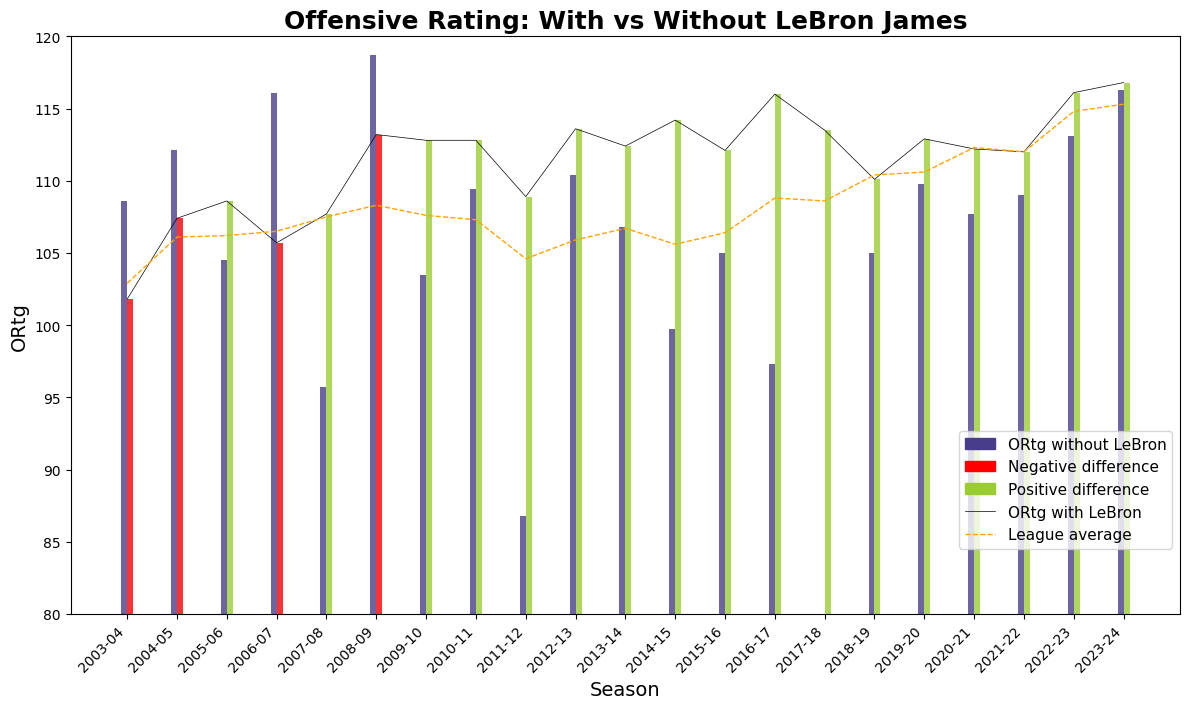

In [151]:
# Bar color function
# input: val (float): The value to determine the color for
# output: str: The color for the bar

def color_bar(val):
    return 'red' if val < 0 else 'yellowgreen'

# Bar plot function

# input: DataFrame, list of strings
# output: None
def ofr_barPlot(data, seasons):
    # Filter the data by the given seasons
    data = data[data.index.get_level_values('Season').isin(seasons)]

    # Get the average offensive rating without LeBron James
    off_rating_without = data['OFR_T'].values

    # Get the average offensive rating with LeBron James
    off_rating_with = data['OFR_L'].values

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(12, 7.2))

    # Set the positions of the bars
    x = np.arange(len(seasons))

    # Set the width of the bars
    width = 0.12

    # Plot bars for OFR without LeBron
    ax.bar(x - width/2, off_rating_without[:len(x)], color='darkslateblue', alpha=0.8, width=width)

    # Plot bars for OFR with LeBron
    ax.bar(x + width/2, off_rating_with[:len(x)], color=[color_bar(val) for val in off_rating_with[:len(x)] - off_rating_without[:len(x)]], alpha=0.8, width=width)

    ax.plot(seasons, off_rating_with[:len(seasons)], color='black', linestyle='-', linewidth=0.5)

    ax.plot(seasons, data['LEAGUE_OFR'], color='orange', linestyle='--', linewidth=1)

    # Set the x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(seasons, fontsize=10, rotation=45, ha='right')

    ax.set_ylim(80, 120)

    # Add labels and title
    ax.set_xlabel('Season', fontsize=14)
    ax.set_ylabel('ORtg', fontsize=14)
    ax.set_title('Offensive Rating: With vs Without LeBron James', fontsize=18, fontweight='bold')

    # Add a legend
    legend_handles = [
        patches.Patch(color='darkslateblue', label='ORtg without LeBron'),
        patches.Patch(color='red', label='Negative difference'),
        patches.Patch(color='yellowgreen', label='Positive difference'),
        Line2D([0], [0], color='black', linestyle='-', linewidth=0.5, label='ORtg with LeBron'),
        Line2D([0], [0], color='orange', linestyle='--', linewidth=1, label='League average')
    ]

    ax.legend(handles=legend_handles, loc='lower right', fontsize=11, bbox_to_anchor=(1, 0.1))

ofr_barPlot(df_advanced, seasons)

plt.tight_layout()

plt.show()


In [152]:
# Correlation between OFR_L and time
correlation_ofr_l = np.corrcoef(df_advanced['OFR_L'], seasons_numeric)[0, 1]

# Correlation between LEAGUE_OFR and time
correlation_league_ofr = np.corrcoef(df_advanced['LEAGUE_OFR'], seasons_numeric)[0, 1]

print(correlation_ofr_l)
print(correlation_league_ofr)

# A value close to 1 indicates that both the Offensive Rating (ORtg) of LeBron James' teams and the league average ORtg 
# increase linearly over time, but not necessarily in relation to each other.

0.7351854328786415
0.8257438024432494


### Observations
he visualization highlights a clear trend of improvement in the Offensive Rating (ORtg) of LeBron's teams over the years, signaling enhanced offensive efficiency and productivity. Importantly, teams with LeBron consistently outperform the league average in ORtg, whereas in his absence, ORtg tends to drop significantly, underscoring LeBron's substantial impact on his teams' offensive performance.

Moreover, except for the initial years of his career, LeBron James has consistently elevated his teams' offensive output, with noticeable spikes in ORtg during his tenure. This pattern underscores LeBron's pivotal role in driving offensive success and boosting his teams' scoring capabilities, ultimately leading to improved overall performance.

### ORtg vs eFG%: Exploring Offensive Efficiency
To delve deeper into LeBron James's impact on offensive performance, we will examine the correlation between his effective field goal percentage (eFG%) and his teams' Offensive Rating (ORtg). This analysis aims to elucidate how LeBron's shooting efficiency influences his team's overall offensive success.

Visualizing this relationship through a kernel density estimation (KDE) plot offers a clear depiction of the correlation between LeBron's individual performance and his teams' ORtg. KDE plots are effective for understanding the distribution of two variables and revealing potential correlations. The shape and orientation of the plot can indicate the strength and direction of the relationship: an elongated shape along the main diagonal suggests a positive correlation, while a different orientation suggests a negative correlation. Moreover, the density of points in specific areas of the plot can highlight clusters or patterns in the data, providing further insights into LeBron's impact on offensive efficiency.

The overlaid Gaussian distributions on the KDE plot offer a visual estimate of the data distribution, enhancing our understanding of the relationships between eFG% and ORtg across LeBron's career.

In [153]:
#correlation between OFR_L and efg
correlation_ofr_l_efg = np.corrcoef(df_advanced['OFR_L'], efg)[0, 1]

print(correlation_ofr_l_efg)

0.7068172799180411


In [154]:
#plot efg and ofr_l

# Reset index and drop NaN values
df2 = df_advanced.reset_index()

# Create joint plot with KDE and data points
plot = sns.jointplot(x=efg, y=df2['OFR_L'], kind='kde', color='steelblue', fill=True, s=100, alpha=0.7, n_levels=50)

# Set figure size
plot.figure.set_figwidth(12)

# Set axis labels and title
plot.set_axis_labels('Effective Field Goal Percentage', 'Offensive Rating (OFR)', fontsize=14)
plot.figure.suptitle('Offensive Rating Analysis with LeBron James and Effective Field Goal Percentage', fontsize=18, fontweight='bold')

# Add labels and title
plot.set_axis_labels('eFG%', 'ORtg', fontsize=14)
plot.figure.suptitle('ORtg vs eFG%: Exploring Offensive Efficiency', fontsize=18, fontweight='bold')



plt.tight_layout()

plt.show()


In [ ]:
#calculate USG mean
usg_mean = df_advanced['USG'].mean()

print("Lebron James' average usage: ", usg_mean)

Lebron James' average usage:  31.576190476190472


### Observations

Observations
The KDE plot clearly illustrates a positive correlation between LeBron's shooting efficiency and his teams' Offensive Rating (ORtg). The elongated shape along the main diagonal indicates a robust relationship, highlighting LeBron's significant impact on his teams' offensive success through his individual shooting efficiency. This correlation underscores how LeBron's scoring ability directly influences his teams' overall offensive performance and success.

This relationship can largely be attributed to LeBron's high Usage Rate, which measures the proportion of team plays involving him while he is on the court. A higher Usage Rate signifies that LeBron is heavily involved in his team's offensive actions, thereby influencing overall efficiency and productivity. The strong positive correlation observed between LeBron's efficiency and his teams' ORtg suggests that his individual contributions play a crucial role in determining his team's offensive output.

LeBron's career Usage Rate of 31.58% ranks him 9th all-time in NBA history, reflecting his exceptional influence on the court. This statistic is calculated based on his field goal attempts, free throw attempts, and turnovers relative to his team's total offensive metrics and playing time. LeBron's consistent presence near the top of this list, particularly in his later years compared to other players, highlights his enduring impact and remarkable offensive prowess throughout his career.



Actual Usage Rate formula:
$$
    \text{Usage Rate} = 100 \times \frac{(\text{Player’s Field Goal Attempts} + 0.44 \times \text{Player’s Free Throw Attempts} + \text{Player’s Turnovers}) \times \text{Team’s Total Minutes}}{(\text{Team’s Total Field Goal Attempts} + 0.44 \times \text{Team’s Total Free Throw Attempts} + \text{Team’s Total Turnovers}) \times 5 \times \text{Player’s Minutes}}
$$

# Conclusion


In conclusion, our analysis of LeBron James' offensive evolution in the NBA has provided valuable insights into his shot selection, shooting efficiency, and impact on team performance over the years. By examining his shot distribution, shooting percentages, and team Offensive Rating (ORtg), we have gained a comprehensive understanding of how LeBron's offensive game has evolved and influenced his teams' success.

Key findings from our analysis include:
- LeBron's shot selection has evolved significantly, with a notable increase in three-point attempts and a more balanced distribution of shots across different areas of the court.
- His shooting efficiency has improved over time, particularly from the three-point line, reflecting his dedication to enhancing his scoring skills.
- LeBron's individual performance, as measured by his shooting efficiency, has a strong positive correlation with his teams' Offensive Rating (ORtg), highlighting his pivotal role in driving offensive success.